In [1]:
Sys.setlocale(category = "LC_ALL", locale = "en_US.UTF-8")

[1] "en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/C"

# Dependencies

In [2]:
pacman::p_load(dplyr, ggplot2, ggbeeswarm, ggpubr, rms)

# Functions

In [3]:
# use codes from Lagattuta et al.
source("/Users/anabbi/git/TiRP/utils.R")

In [4]:
prepare_mixcr.fx <- function(df) {
  onefle <- df
  # onefle <- read.table(paste0(indir, fle), sep = "\t", header = TRUE, stringsAsFactors = F)
  onefle$TRBV <- gsub("[*]0.*", "", onefle$allVHitsWithScore)
  onefle$TRBJ <- gsub("[*]0.*", "", onefle$allJHitsWithScore)
  onefle <- onefle[, c("basename","aaSeqCDR3", "TRBV", "TRBJ", "cloneCount", "cloneFraction")]
  onefle$length <- sapply(onefle$aaSeqCDR3, function(x) nchar(x))
  # only cdr3b with length between 12 and 17, for now
  onefle <- onefle[onefle$length >= 12 & onefle$length <= 17, ]
  onefle$Vmotif <- sapply(onefle$aaSeqCDR3, function(x) substr(x, 1, 3))

  # frame_type is out if aaSeqCDR3 contains either * or _
  onefle$frame_type <- sapply(onefle$aaSeqCDR3, function(x) ifelse(grepl("[*]|[_]", x), "out", "in"))

  poss <- get_positions(17)

  for (i in 1:6) {
    if (i >= 4) {
      # leave the vmotif out (the first three), take aminoacid of position
      onefle$new <- sapply(onefle$aaSeqCDR3, function(x) substr(x, i, i))
      # print(int_all_1$new)
      colnames(onefle)[ncol(onefle)] <- paste("p", poss[i], sep = "")
    }
  }
  onefle$p110 <- sapply(onefle$aaSeqCDR3, function(x) ifelse(nchar(x) > 12, substr(x, 7, 7), "*"))
  onefle$p111 <- sapply(onefle$aaSeqCDR3, function(x) ifelse(nchar(x) > 14, substr(x, 8, 8), "*"))
  onefle$"p111.1" <- sapply(onefle$aaSeqCDR3, function(x) ifelse(nchar(x) > 16, substr(x, 9, 9), "*"))
  onefle$"p112.1" <- sapply(onefle$aaSeqCDR3, function(x) ifelse(nchar(x) > 15, substr(x, nchar(x) - 7, nchar(x) - 7), "*"))
  onefle$"p112" <- sapply(onefle$aaSeqCDR3, function(x) ifelse(nchar(x) > 13, substr(x, nchar(x) - 6, nchar(x) - 6), "*"))

  for (i in 5:0) { # get last 5 amino acids
    # if (i != 5) { # not sure why this is here
    onefle$new <- sapply(onefle$aaSeqCDR3, function(x) substr(x, nchar(x) - i, nchar(x) - i))
    colnames(onefle)[ncol(onefle)] <- paste("p", poss[length(poss) - i], sep = "")
    # }
  }

  # last 4 amino acids is the Jmotif
  onefle$Jmotif <- sapply(onefle$aaSeqCDR3, function(x) substr(x, nchar(x) - 4, nchar(x)))

  # just to match the format with the function from lagattuta
  data <- onefle
  data$sequence <- data$aaSeqCDR3
  data <- add_percentAA()
  onefle <- data

  onefle$sequence <- NULL

  vars <- c("frame_type", "TRBV", "TRBJ", "Vmotif", "Jmotif", "length", "p107", "p108", "p109", "p110", "p111", "p111.1", "p112.1", "p112", "p113", "p114") # add 113 and 114, just in case (they are not the midregion as per lagattuta)

  ohe_seqdat <- data.frame(matrix(nrow = nrow(onefle), ncol = 0))
  for (i in vars) {
    
    if( length(levels(factor(onefle[[i]]) ))> 1){

    ohe_vars <- as.data.frame(model.matrix(~ factor(onefle[[i]]) - 1))
    colnames(ohe_vars) <- gsub(".*)", "", colnames(ohe_vars))
    colnames(ohe_vars) <- paste0(i, "_is_", colnames(ohe_vars))
    ohe_seqdat <- cbind(ohe_seqdat, ohe_vars)
  }
  }

  onefle_ohe_seqdat <- cbind(onefle, ohe_seqdat)

  return(onefle_ohe_seqdat)
}


In [5]:
source("/Users/anabbi/git/ped_CapTCRseq/R/ggplot2_theme.R")
source("/Users/anabbi/git/ped_CapTCRseq/R/color_schemes.R")
source("/Users/anabbi/git/ped_CapTCRseq/R/Misc_functions.R")

# Paths

In [6]:
datapath <- "/Users/anabbi/OneDrive - UHN/Documents/INTERCEPT/Data/"
plotpath <- "/Users/anabbi/OneDrive - UHN/Documents/INTERCEPT/Plots/"
manifestpath <- "/Users/anabbi/OneDrive - UHN/Documents/INTERCEPT/Manifests/"
gitpath <- "/Users/anabbi/git/ped_CapTCRseq/"

In [7]:
h4hpath <- "/Users/anabbi/Desktop/H4H/INTERCEPT/"

# Main

# Define features

In [8]:
meta_div <- readr::read_rds(paste0(datapath, "capTCRseq/meta_div_goodsamples.rds"))

In [9]:
head(meta_div)

sample_id       Patient      cycle FOLD ATC Age Disease_type TE_fold CD3 EM
287 CHP_10YO_M_00   CHP_10YO_M   X00   NA   NA  NA  Normal       NA      NA  NA
288 CHP_11YO_M_00   CHP_11YO_M   X00   NA   NA  NA  Normal       NA      NA  NA
289 CHP_15YO_F_A_00 CHP_15YO_F_A X00   NA   NA  NA  Normal       NA      NA  NA
290 CHP_15YO_F_B_00 CHP_15YO_F_B X00   NA   NA  NA  Normal       NA      NA  NA
291 CHP_15YO_M_00   CHP_15YO_M   X00   NA   NA  NA  Normal       NA      NA  NA
292 CHP_16YO_M_00   CHP_16YO_M   X00   NA   NA  NA  Normal       NA      NA  NA
    ... estimated_Shannon SE_Shannon observed_Simpson estimated_Simpson
287 ... 10.601            0.073       8.556            8.561           
288 ... 11.614            0.054      10.406           10.414           
289 ...  8.989            0.036       8.560            8.570           
290 ...  6.334            0.040       5.870            5.876           
291 ... 21.120            0.040      20.321           20.339           
292 ...  3.973            0.007       3.944            3.946           
    SE_Simpson basename             
287 0.094      CHP_10YO-M_PBMC_DNA  
288 0.066      CHP_11YO-M_PBMC_DNA  
289 0.060      CHP_15YO-F-A_PBMC_DNA
290 0.066      CHP_15YO-F-B_PBMC_DNA
291 0.068      CHP_15YO-M_PBMC_DNA  
292 0.013      CHP_16YO-M_PBMC_DNA  
    file                                                                  
287 batchNormal_16Apr2020/mixcr/clones/CLONES_TRBCHP_10YO-M_PBMC_DNA.txt  
288 batchNormal_16Apr2020/mixcr/clones/CLONES_TRBCHP_11YO-M_PBMC_DNA.txt  
289 batchNormal_16Apr2020/mixcr/clones/CLONES_TRBCHP_15YO-F-A_PBMC_DNA.txt
290 batchNormal_16Apr2020/mixcr/clones/CLONES_TRBCHP_15YO-F-B_PBMC_DNA.txt
291 batchNormal_16Apr2020/mixcr/clones/CLONES_TRBCHP_15YO-M_PBMC_DNA.txt  
292 batchNormal_16Apr2020/mixcr/clones/CLONES_TRBCHP_16YO-M_PBMC_DNA.txt  
    sampletype Group log10shann
287 PBMC       CHP   1.0249370 
288 PBMC       CHP   1.0647200 
289 PBMC       CHP   0.9533731 
290 PBMC       CHP   0.8014037 
291 PBMC       CHP   1.3244882 
292 PBMC       CHP   0.5990092

In [10]:
table(meta_div$sampletype)


cfDNA  PBMC Tumor 
  274   558    18 

In [11]:
meta_div <- meta_div[ !meta_div$Disease_type %in% c("Normal", "LFS"), ]

In [12]:
meta_div <- meta_div[ meta_div$sampletype != "Tumor",]

In [13]:
meta_div <- meta_div[!is.na(meta_div$basename),]

In [14]:
head(meta_div)

sample_id  Patient cycle FOLD ATC    Age Disease_type TE_fold CD3 EM ...
302 CHP_319_05 CHP_319 X05   1.2    0.00  1  HR ALL       1.2     0   NA ...
320 CHP_323_03 CHP_323 X03   0.0  786.24  1  HR ALL       0.0     0   NA ...
322 CHP_323_05 CHP_323 X05   0.0  979.50  1  HR ALL       0.0     0   NA ...
327 CHP_324_05 CHP_324 X05   0.0    0.00 12  T-ALL        0.0     0   NA ...
346 CHP_328_04 CHP_328 X04   0.0  130.82  7  SR ALL       0.0     0   NA ...
347 CHP_328_05 CHP_328 X05   0.0   91.16  7  SR ALL       0.0     0   NA ...
    estimated_Shannon SE_Shannon observed_Simpson estimated_Simpson SE_Simpson
302  13.439           1.217       10.248           11.626           1.269     
320  37.986           0.367       33.204           33.544           0.638     
322  85.174           2.255       32.669           33.190           2.327     
327 130.246           0.574       79.994           80.126           0.912     
346 224.003           0.477      133.121          133.198           0.669     
347  87.712           0.563       62.759           62.967           0.625     
    basename           
302 CHP_319-05-PBMC-DNA
320 CHP_323-03-PBMC-DNA
322 CHP_323-05-PBMC-DNA
327 CHP_324-05_PBMC-DNA
346 CHP-328-04-PBMC-DNA
347 CHP-328-05-PBMC-DNA
    file                                                                        
302 batch2_Aug62019/mixcr/clones/CLONES_TRBCHP_319-05-PBMC-DNA.txt              
320 batch4_19Aug2019/mixcr/clones/CLONES_TRBCHP_323-03-PBMC-DNA.txt             
322 batch7_25Oct2019/mixcr/clones/CLONES_TRBCHP_323-05-PBMC-DNA.txt             
327 remaining_batch_2_22April2021/mixcr/clones/CLONES_TRBCHP_324-05_PBMC-DNA.txt
346 remaining_batch_4_28June2021/mixcr/clones/CLONES_TRBCHP-328-04-PBMC-DNA.txt 
347 remaining_batch_4_28June2021/mixcr/clones/CLONES_TRBCHP-328-05-PBMC-DNA.txt 
    sampletype Group log10shann
302 PBMC       CHP   1.074743  
320 PBMC       CHP   1.576595  
322 PBMC       CHP   1.912504  
327 PBMC       CHP   2.113673  
346 PBMC       CHP   2.349757  
347 PBMC       CHP   1.941119

In [15]:
colnames(meta_div)

[1] "sample_id"          "Patient"            "cycle"             
 [4] "FOLD"               "ATC"                "Age"               
 [7] "Disease_type"       "TE_fold"            "CD3"               
[10] "EM"                 "CM"                 "Naïve"             
[13] "SCM"                "TE"                 "EM%"               
[16] "CM%"                "Naïve%"             "SCM%"              
[19] "TE%"                "Naïve/TE"           "N+CM+SCM/TE+EM"    
[22] "PD-1"               "PDL1"               "LAG3"              
[25] "TIM3"               "CTLA4"              "PD1%"              
[28] "PDL1%"              "LAG3%"              "TIM3%"             
[31] "CTLA4%"             "Any NCR"            "PD1 + LAG3 + TIM3" 
[34] "cancergroup"        "agegroup"           "foldgroup"         
[37] "Remission"          "Relapse"            "Transplant"        
[40] "CART"               "vital_status"       "LOF"               
[43] "TRB"                "Reads"              "CPKR"              
[46] "Average_reads"      "VMR"                "Max_reads"         
[49] "Singletons"         "Doubletons"         "qD"                
[52] "Sample_Coverage"    "observed_Richness"  "estimated_Richness"
[55] "SE_Richeness"       "observed_Shannon"   "estimated_Shannon" 
[58] "SE_Shannon"         "observed_Simpson"   "estimated_Simpson" 
[61] "SE_Simpson"         "basename"           "file"              
[64] "sampletype"         "Group"              "log10shann"

In [17]:
phenodat <- meta_div[!is.na(meta_div$TE_fold), c(
    "basename", "sample_id", "Patient", "TE_fold", "ATC", "Age", "EM%", "CM%", "Naïve%", "SCM%", "TE%", "PD1%", "LAG3%", "TIM3%", "Relapse", # all numeric
    "cycle", "Disease_type", "cancergroup", "sampletype", "foldgroup"
)] # all character vars


In [18]:
rownames(phenodat) <- phenodat$basename
# phenodat$basename <- NULL

In [19]:
dat = data.frame(matrix(nrow=nrow(phenodat), ncol=0))

In [20]:
rownames(dat) <- rownames(phenodat)

In [21]:
# numeric features as they are
dat$TE_fold <- phenodat$TE_fold
dat$Relapse <- phenodat$Relapse
dat$ATC <- phenodat$ATC
dat$Age <- phenodat$Age
dat$EM <- phenodat$`EM%`
dat$CM <- phenodat$`CM%`
dat$Naive <- phenodat$`Naïve%`
dat$SCM <- phenodat$`SCM%`
dat$TE <- phenodat$`TE%`
dat$PD1 <- phenodat$`PD1%`
dat$LAG3 <- phenodat$`LAG3%`
dat$TIM3 <- phenodat$`TIM3%`


In [22]:
table(dat$Relapse)


  0   1 
386  82 

In [23]:
myvariables <- c("cycle", "Disease_type", "cancergroup", "sampletype", "foldgroup")

In [24]:
# OHE
for(i in myvariables){
ohe_vars <- as.data.frame(model.matrix(~factor(phenodat[[i]]) - 1))
colnames(ohe_vars) <- gsub(".*)", "", colnames(ohe_vars))
colnames(ohe_vars) <- paste0(i, "_is_", colnames(ohe_vars))
dat <- cbind(dat, ohe_vars)
}

In [25]:
head(dat)

TE_fold Relapse ATC    Age EM CM Naive SCM TE PD1 ...
CHP_319-05-PBMC-DNA 1.2     1         0.00  1  NA NA NA    NA  NA NA  ...
CHP_323-03-PBMC-DNA 0.0     0       786.24  1  NA NA NA    NA  NA NA  ...
CHP_323-05-PBMC-DNA 0.0     0       979.50  1  NA NA NA    NA  NA NA  ...
CHP_324-05_PBMC-DNA 0.0     0         0.00 12  NA NA NA    NA  NA NA  ...
CHP-328-04-PBMC-DNA 0.0     0       130.82  7  NA NA NA    NA  NA NA  ...
CHP-328-05-PBMC-DNA 0.0     0        91.16  7  NA NA NA    NA  NA NA  ...
                    Disease_type_is_WILMS cancergroup_is_Leukemia
CHP_319-05-PBMC-DNA 0                     1                      
CHP_323-03-PBMC-DNA 0                     1                      
CHP_323-05-PBMC-DNA 0                     1                      
CHP_324-05_PBMC-DNA 0                     0                      
CHP-328-04-PBMC-DNA 0                     1                      
CHP-328-05-PBMC-DNA 0                     1                      
                    cancergroup_is_Lymphoma cancergroup_is_Solid tumors
CHP_319-05-PBMC-DNA 0                       0                          
CHP_323-03-PBMC-DNA 0                       0                          
CHP_323-05-PBMC-DNA 0                       0                          
CHP_324-05_PBMC-DNA 0                       0                          
CHP-328-04-PBMC-DNA 0                       0                          
CHP-328-05-PBMC-DNA 0                       0                          
                    cancergroup_is_T-cell malignancies sampletype_is_cfDNA
CHP_319-05-PBMC-DNA 0                                  0                  
CHP_323-03-PBMC-DNA 0                                  0                  
CHP_323-05-PBMC-DNA 0                                  0                  
CHP_324-05_PBMC-DNA 1                                  0                  
CHP-328-04-PBMC-DNA 0                                  0                  
CHP-328-05-PBMC-DNA 0                                  0                  
                    sampletype_is_PBMC foldgroup_is_High
CHP_319-05-PBMC-DNA 1                  0                
CHP_323-03-PBMC-DNA 1                  0                
CHP_323-05-PBMC-DNA 1                  0                
CHP_324-05_PBMC-DNA 1                  0                
CHP-328-04-PBMC-DNA 1                  0                
CHP-328-05-PBMC-DNA 1                  0                
                    foldgroup_is_Indeterminate foldgroup_is_Low
CHP_319-05-PBMC-DNA 0                          1               
CHP_323-03-PBMC-DNA 0                          1               
CHP_323-05-PBMC-DNA 0                          1               
CHP_324-05_PBMC-DNA 0                          1               
CHP-328-04-PBMC-DNA 0                          1               
CHP-328-05-PBMC-DNA 0                          1

In [26]:
readr::write_rds(dat, paste0(datapath, "ML/int_metadat.rds"))

sequence data

In [27]:
# meta_div <- readr::read_rds(file = paste0(datapath,"capTCRseq/meta_div_goodsamples.rds"))

In [28]:
load(file = paste0(datapath,"capTCRseq/TRBfiles.RData"))

In [29]:
# get good samples
file_df_dedup_trb <- file_df_dedup_trb[ file_df_dedup_trb$samplename %in% rownames(dat), ]

In [30]:
head(file_df_dedup_trb)

file_list                                                           
2 batch_reseq_24Feb2020/mixcr/clones/CLONES_TRBCHP_350-01-PBMC-DNA.txt
3 batch_reseq_24Feb2020/mixcr/clones/CLONES_TRBCHP_350-02-PBMC-DNA.txt
4 batch_reseq_24Feb2020/mixcr/clones/CLONES_TRBCHP_350-03-PBMC-DNA.txt
5 batch_reseq_24Feb2020/mixcr/clones/CLONES_TRBCHP_350-04-PBMC-DNA.txt
7 batch_reseq_24Feb2020/mixcr/clones/CLONES_TRBCHP_354-01-PBMC-DNA.txt
8 batch_reseq_24Feb2020/mixcr/clones/CLONES_TRBCHP_356-03-PBMC-DNA.txt
  samplename          size  
2 CHP_350-01-PBMC-DNA  85631
3 CHP_350-02-PBMC-DNA 143632
4 CHP_350-03-PBMC-DNA 107190
5 CHP_350-04-PBMC-DNA  54188
7 CHP_354-01-PBMC-DNA   3728
8 CHP_356-03-PBMC-DNA   1573

In [31]:
dim(file_df_dedup_trb)

[1] 468   3

In [32]:
h4hpath

[1] "/Users/anabbi/Desktop/H4H/INTERCEPT/"

In [33]:
head(rownames(dat))

[1] "CHP_319-05-PBMC-DNA" "CHP_323-03-PBMC-DNA" "CHP_323-05-PBMC-DNA"
[4] "CHP_324-05_PBMC-DNA" "CHP-328-04-PBMC-DNA" "CHP-328-05-PBMC-DNA"

In [34]:
myfilelist <- file_df_dedup_trb$file_list[ match(rownames(dat), file_df_dedup_trb$samplename)] 

In [35]:
# read in the files in list
myfiles <- lapply(myfilelist, function(x) read.table(paste0(h4hpath, "NextSeq/",x), sep = "\t", header = TRUE, stringsAsFactors = F)  )
# add sample name to each file
names(myfiles) <- basename(myfilelist)
# add names as column to their corresponding dataframe
myfiles <- lapply(names(myfiles), function(x) {myfiles[[x]]$basename <- x; return(myfiles[[x]])})

In [36]:
int_all <- do.call(rbind, myfiles)

In [37]:
dim(int_all)

[1] 71412    36

In [38]:

  onefle <- int_all
  # onefle <- read.table(paste0(indir, fle), sep = "\t", header = TRUE, stringsAsFactors = F)
  onefle$TRBV <- gsub("[*]0.*", "", onefle$allVHitsWithScore)
  onefle$TRBJ <- gsub("[*]0.*", "", onefle$allJHitsWithScore)
  onefle <- onefle[, c("basename","aaSeqCDR3", "TRBV", "TRBJ", "cloneCount", "cloneFraction")]
  onefle$length <- sapply(onefle$aaSeqCDR3, function(x) nchar(x))
  # only cdr3b with length between 12 and 17, for now
  onefle <- onefle[onefle$length >= 12 & onefle$length <= 17, ]
  onefle$Vmotif <- sapply(onefle$aaSeqCDR3, function(x) substr(x, 1, 3))

  # frame_type is out if aaSeqCDR3 contains either * or _
  onefle$frame_type <- sapply(onefle$aaSeqCDR3, function(x) ifelse(grepl("[*]|[_]", x), "out", "in"))

  poss <- get_positions(17)

  for (i in 1:6) {
    if (i >= 4) {
      # leave the vmotif out (the first three), take aminoacid of position
      onefle$new <- sapply(onefle$aaSeqCDR3, function(x) substr(x, i, i))
      # print(int_all_1$new)
      colnames(onefle)[ncol(onefle)] <- paste("p", poss[i], sep = "")
    }
  }
  onefle$p110 <- sapply(onefle$aaSeqCDR3, function(x) ifelse(nchar(x) > 12, substr(x, 7, 7), "*"))
  onefle$p111 <- sapply(onefle$aaSeqCDR3, function(x) ifelse(nchar(x) > 14, substr(x, 8, 8), "*"))
  onefle$"p111.1" <- sapply(onefle$aaSeqCDR3, function(x) ifelse(nchar(x) > 16, substr(x, 9, 9), "*"))
  onefle$"p112.1" <- sapply(onefle$aaSeqCDR3, function(x) ifelse(nchar(x) > 15, substr(x, nchar(x) - 7, nchar(x) - 7), "*"))
  onefle$"p112" <- sapply(onefle$aaSeqCDR3, function(x) ifelse(nchar(x) > 13, substr(x, nchar(x) - 6, nchar(x) - 6), "*"))

  for (i in 5:0) { # get last 5 amino acids
    # if (i != 5) { # not sure why this is here
    onefle$new <- sapply(onefle$aaSeqCDR3, function(x) substr(x, nchar(x) - i, nchar(x) - i))
    colnames(onefle)[ncol(onefle)] <- paste("p", poss[length(poss) - i], sep = "")
    # }
  }

  # last 4 amino acids is the Jmotif
  onefle$Jmotif <- sapply(onefle$aaSeqCDR3, function(x) substr(x, nchar(x) - 4, nchar(x)))

  # just to match the format with the function from lagattuta
  data <- onefle
  data$sequence <- data$aaSeqCDR3
  data <- add_percentAA()
  onefle <- data

  onefle$sequence <- NULL

  vars <- c("frame_type", "TRBV", "TRBJ", "Vmotif", "Jmotif", "length", "p107", "p108", "p109", "p110", "p111", "p111.1", "p112.1", "p112", "p113", "p114") # add 113 and 114, just in case (they are not the midregion as per lagattuta)

  ohe_seqdat <- data.frame(matrix(nrow = nrow(onefle), ncol = 0))
  for (i in vars) {
    
    if( length(levels(factor(onefle[[i]]) ))> 1){

    ohe_vars <- as.data.frame(model.matrix(~ factor(onefle[[i]]) - 1))
    colnames(ohe_vars) <- gsub(".*)", "", colnames(ohe_vars))
    colnames(ohe_vars) <- paste0(i, "_is_", colnames(ohe_vars))
    ohe_seqdat <- cbind(ohe_seqdat, ohe_vars)
  }
  }

  onefle_ohe_seqdat <- cbind(onefle, ohe_seqdat)



In [39]:
# int_all_1 <- prepare_mixcr.fx(int_all)

In [40]:
head(onefle_ohe_seqdat)

basename                          aaSeqCDR3        TRBV     TRBJ   
1 CLONES_TRBCHP_319-05-PBMC-DNA.txt CASRERIAPGNTIYF  TRBV6-5  TRBJ1-3
2 CLONES_TRBCHP_319-05-PBMC-DNA.txt CSARDRTGMSTDTQYF TRBV20-1 TRBJ2-3
3 CLONES_TRBCHP_319-05-PBMC-DNA.txt CASRLGTGHENTEAFF TRBV19   TRBJ1-1
4 CLONES_TRBCHP_319-05-PBMC-DNA.txt CATSRDWTVSYEQYF  TRBV15   TRBJ2-7
5 CLONES_TRBCHP_319-05-PBMC-DNA.txt CASSRNRVRYGYTF   TRBV11-2 TRBJ1-2
8 CLONES_TRBCHP_319-05-PBMC-DNA.txt CASSLTGGEYAEQYF  TRBV7-2  TRBJ2-7
  cloneCount cloneFraction length Vmotif frame_type p107 ... p114_is_M
1 13         0.15116279    15     CAS    in         R    ... 0        
2 11         0.12790698    16     CSA    in         R    ... 0        
3  9         0.10465116    16     CAS    in         R    ... 0        
4  9         0.10465116    15     CAT    in         S    ... 0        
5  6         0.06976744    14     CAS    in         S    ... 0        
8  5         0.05813953    15     CAS    in         S    ... 0        
  p114_is_N p114_is_P p114_is_Q p114_is_R p114_is_S p114_is_T p114_is_V
1 1         0         0         0         0         0         0        
2 0         0         0         0         0         0         0        
3 0         0         0         0         0         1         0        
4 0         0         0         0         0         0         0        
5 0         0         0         0         0         0         0        
8 0         0         0         0         0         0         0        
  p114_is_W p114_is_Y
1 0         0        
2 0         0        
3 0         0        
4 0         1        
5 0         1        
8 0         0

In [41]:
head(rownames(dat))

[1] "CHP_319-05-PBMC-DNA" "CHP_323-03-PBMC-DNA" "CHP_323-05-PBMC-DNA"
[4] "CHP_324-05_PBMC-DNA" "CHP-328-04-PBMC-DNA" "CHP-328-05-PBMC-DNA"

In [42]:
onefle_ohe_seqdat$basename <- gsub(".txt", "", onefle_ohe_seqdat$basename)
onefle_ohe_seqdat$basename <- gsub("CLONES_TRB", "", onefle_ohe_seqdat$basename)

In [43]:
readr::write_rds(onefle_ohe_seqdat, paste0(datapath, "ML/", "int_ohe_trbseq.rds") )

In [44]:
head(unique(onefle_ohe_seqdat$basename))

[1] "CHP_319-05-PBMC-DNA" "CHP_323-03-PBMC-DNA" "CHP_323-05-PBMC-DNA"
[4] "CHP_324-05_PBMC-DNA" "CHP-328-04-PBMC-DNA" "CHP-328-05-PBMC-DNA"

In [45]:
head(onefle_ohe_seqdat)

basename            aaSeqCDR3        TRBV     TRBJ    cloneCount
1 CHP_319-05-PBMC-DNA CASRERIAPGNTIYF  TRBV6-5  TRBJ1-3 13        
2 CHP_319-05-PBMC-DNA CSARDRTGMSTDTQYF TRBV20-1 TRBJ2-3 11        
3 CHP_319-05-PBMC-DNA CASRLGTGHENTEAFF TRBV19   TRBJ1-1  9        
4 CHP_319-05-PBMC-DNA CATSRDWTVSYEQYF  TRBV15   TRBJ2-7  9        
5 CHP_319-05-PBMC-DNA CASSRNRVRYGYTF   TRBV11-2 TRBJ1-2  6        
8 CHP_319-05-PBMC-DNA CASSLTGGEYAEQYF  TRBV7-2  TRBJ2-7  5        
  cloneFraction length Vmotif frame_type p107 ... p114_is_M p114_is_N p114_is_P
1 0.15116279    15     CAS    in         R    ... 0         1         0        
2 0.12790698    16     CSA    in         R    ... 0         0         0        
3 0.10465116    16     CAS    in         R    ... 0         0         0        
4 0.10465116    15     CAT    in         S    ... 0         0         0        
5 0.06976744    14     CAS    in         S    ... 0         0         0        
8 0.05813953    15     CAS    in         S    ... 0         0         0        
  p114_is_Q p114_is_R p114_is_S p114_is_T p114_is_V p114_is_W p114_is_Y
1 0         0         0         0         0         0         0        
2 0         0         0         0         0         0         0        
3 0         0         0         1         0         0         0        
4 0         0         0         0         0         0         1        
5 0         0         0         0         0         0         1        
8 0         0         0         0         0         0         0

In [46]:
dat$basename <- rownames(dat)

In [47]:
colnames(dat)

[1] "TE_fold"                            "Relapse"                           
 [3] "ATC"                                "Age"                               
 [5] "EM"                                 "CM"                                
 [7] "Naive"                              "SCM"                               
 [9] "TE"                                 "PD1"                               
[11] "LAG3"                               "TIM3"                              
[13] "cycle_is_X01"                       "cycle_is_X02"                      
[15] "cycle_is_X03"                       "cycle_is_X04"                      
[17] "cycle_is_X05"                       "Disease_type_is_ALCL"              
[19] "Disease_type_is_ALL"                "Disease_type_is_AML"               
[21] "Disease_type_is_ARMS"               "Disease_type_is_BL"                
[23] "Disease_type_is_BLL"                "Disease_type_is_CML"               
[25] "Disease_type_is_DLBCL"              "Disease_type_is_ERMS"              
[27] "Disease_type_is_EWS"                "Disease_type_is_HB"                
[29] "Disease_type_is_HD"                 "Disease_type_is_HR ALL"            
[31] "Disease_type_is_MS NB"              "Disease_type_is_NB"                
[33] "Disease_type_is_OS"                 "Disease_type_is_PMBCL"             
[35] "Disease_type_is_SR ALL"             "Disease_type_is_T-ALL"             
[37] "Disease_type_is_WILMS"              "cancergroup_is_Leukemia"           
[39] "cancergroup_is_Lymphoma"            "cancergroup_is_Solid tumors"       
[41] "cancergroup_is_T-cell malignancies" "sampletype_is_cfDNA"               
[43] "sampletype_is_PBMC"                 "foldgroup_is_High"                 
[45] "foldgroup_is_Indeterminate"         "foldgroup_is_Low"                  
[47] "basename"

# merge phenodata and seq

In [9]:
dat <- readr::read_rds(paste0(datapath, "ML/int_metadat.rds"))

In [10]:
onefle_ohe_seqdat <- readr::read_rds( paste0(datapath, "ML/", "int_ohe_trbseq.rds") )

In [11]:
dat$basename <- rownames(dat)

In [86]:
merge_m <- merge(dat, onefle_ohe_seqdat, by = "basename")

In [87]:
colnames(merge_m[, grepl("_is_\\*", colnames(merge_m))])

[1] "Vmotif_is_**L"   "Vmotif_is_*AS"   "Vmotif_is_*GQ"   "Vmotif_is_*GT"  
 [5] "Vmotif_is_*KR"   "Vmotif_is_*QL"   "Vmotif_is_*SA"   "Vmotif_is_*SE"  
 [9] "Vmotif_is_*SL"   "Vmotif_is_*SS"   "Jmotif_is_**AFF" "Jmotif_is_*DQYF"
[13] "Jmotif_is_*EAFF" "Jmotif_is_*ELFF" "Jmotif_is_*EQFF" "Jmotif_is_*EQYF"
[17] "Jmotif_is_*EQYS" "Jmotif_is_*GEFF" "Jmotif_is_*GLFF" "Jmotif_is_*GQYF"
[21] "Jmotif_is_*GSFF" "Jmotif_is_*GYTF" "Jmotif_is_*GYTL" "Jmotif_is_*KLFF"
[25] "Jmotif_is_*KQFF" "Jmotif_is_*KQYF" "Jmotif_is_*KTVF" "Jmotif_is_*PLHF"
[29] "Jmotif_is_*PQHF" "Jmotif_is_*QQYF" "Jmotif_is_*RAQG" "Jmotif_is_*SKYF"
[33] "Jmotif_is_*SQYF" "Jmotif_is_*SYTF" "Jmotif_is_*TQHF" "Jmotif_is_*TQYF"
[37] "Jmotif_is_*VAFF" "p107_is_*"       "p108_is_*"       "p109_is_*"      
[41] "p110_is_*"       "p111_is_*"       "p111.1_is_*"     "p112.1_is_*"    
[45] "p112_is_*"       "p113_is_*"       "p114_is_*"

In [88]:
# remove columns with _is_*
merge_m <- merge_m[, !grepl("_is__", colnames(merge_m))]
merge_m <- merge_m[, !grepl("_is_\\*", colnames(merge_m))]

In [89]:
head(merge_m)

basename            TE_fold Relapse ATC Age EM CM Naive SCM TE ... p114_is_M
1 CHP_319-05-PBMC-DNA 1.2     1       0   1   NA NA NA    NA  NA ... 0        
2 CHP_319-05-PBMC-DNA 1.2     1       0   1   NA NA NA    NA  NA ... 0        
3 CHP_319-05-PBMC-DNA 1.2     1       0   1   NA NA NA    NA  NA ... 0        
4 CHP_319-05-PBMC-DNA 1.2     1       0   1   NA NA NA    NA  NA ... 0        
5 CHP_319-05-PBMC-DNA 1.2     1       0   1   NA NA NA    NA  NA ... 0        
6 CHP_319-05-PBMC-DNA 1.2     1       0   1   NA NA NA    NA  NA ... 0        
  p114_is_N p114_is_P p114_is_Q p114_is_R p114_is_S p114_is_T p114_is_V
1 1         0         0         0         0         0         0        
2 0         0         0         0         0         0         0        
3 0         0         0         0         0         1         0        
4 0         0         0         0         0         0         0        
5 0         0         0         0         0         0         0        
6 0         0         0         0         0         0         0        
  p114_is_W p114_is_Y
1 0         0        
2 0         0        
3 0         0        
4 0         1        
5 0         1        
6 0         0

add HLA

In [90]:
allhlas <- readr::read_rds(paste0(datapath, "/HLA/INT_allHLA_postqc.rds"))

In [91]:
colnames(allhlas) <- paste0("HLA_", colnames(allhlas))
# remove *
colnames(allhlas) <- gsub("\\*", "", colnames(allhlas))

In [92]:
head(allhlas)

HLA_A02:01:01 HLA_A01:01:01 HLA_A11:01:01 HLA_A26:01:01 HLA_A31:01:02
315-05 1             0             0             0             0            
319-05 0             1             0             0             0            
323-03 0             0             1             0             0            
329-04 0             0             0             2             0            
330-05 1             0             0             0             0            
331-04 1             0             0             1             0            
       HLA_A03:01:01 HLA_A02:05:01 HLA_A23:01:01 HLA_A24:02:01 HLA_A30:01:01
315-05 0             1             0             0             0            
319-05 1             0             0             0             0            
323-03 0             0             1             0             0            
329-04 0             0             0             0             0            
330-05 0             0             0             0             0            
331-04 0             0             0             0             0            
       ... HLA_DRB301:01:02 HLA_DRB501:01:01 HLA_DRB401:03:01 HLA_DRB303:01:01
315-05 ... 0                0                0                1               
319-05 ... 1                0                0                0               
323-03 ... 0                0                1                0               
329-04 ... 0                1                0                0               
330-05 ... 0                0                1                0               
331-04 ... 0                0                1                0               
       HLA_DRB401:01:01 HLA_DRB301:62:01 HLA_DRB401:03:02 HLA_DRB502:02:01
315-05 0                0                0                0               
319-05 0                0                0                0               
323-03 0                0                0                0               
329-04 0                0                0                1               
330-05 0                0                0                0               
331-04 0                0                0                0               
       HLA_DRB501:02:01 HLA_DRB401:03:01:02N
315-05 0                0                   
319-05 0                0                   
323-03 0                0                   
329-04 0                0                   
330-05 0                0                   
331-04 0                0

In [93]:
rownames(allhlas) <- gsub("-.*", "", rownames(allhlas))
rownames(allhlas) <- paste0("CHP_", rownames(allhlas))

In [94]:
head(allhlas)

HLA_A02:01:01 HLA_A01:01:01 HLA_A11:01:01 HLA_A26:01:01 HLA_A31:01:02
CHP_315 1             0             0             0             0            
CHP_319 0             1             0             0             0            
CHP_323 0             0             1             0             0            
CHP_329 0             0             0             2             0            
CHP_330 1             0             0             0             0            
CHP_331 1             0             0             1             0            
        HLA_A03:01:01 HLA_A02:05:01 HLA_A23:01:01 HLA_A24:02:01 HLA_A30:01:01
CHP_315 0             1             0             0             0            
CHP_319 1             0             0             0             0            
CHP_323 0             0             1             0             0            
CHP_329 0             0             0             0             0            
CHP_330 0             0             0             0             0            
CHP_331 0             0             0             0             0            
        ... HLA_DRB301:01:02 HLA_DRB501:01:01 HLA_DRB401:03:01 HLA_DRB303:01:01
CHP_315 ... 0                0                0                1               
CHP_319 ... 1                0                0                0               
CHP_323 ... 0                0                1                0               
CHP_329 ... 0                1                0                0               
CHP_330 ... 0                0                1                0               
CHP_331 ... 0                0                1                0               
        HLA_DRB401:01:01 HLA_DRB301:62:01 HLA_DRB401:03:02 HLA_DRB502:02:01
CHP_315 0                0                0                0               
CHP_319 0                0                0                0               
CHP_323 0                0                0                0               
CHP_329 0                0                0                1               
CHP_330 0                0                0                0               
CHP_331 0                0                0                0               
        HLA_DRB501:02:01 HLA_DRB401:03:01:02N
CHP_315 0                0                   
CHP_319 0                0                   
CHP_323 0                0                   
CHP_329 0                0                   
CHP_330 0                0                   
CHP_331 0                0

In [95]:
merge_m$Patient <- gsub("-.*", "", merge_m$basename)

In [96]:
# bind allhlas to merge_m by matching rownames(allhlas) to merge_m$Patient
merge_m <- cbind(merge_m, allhlas[ match(merge_m$Patient, rownames(allhlas)), ])

In [97]:
# head(merge_m)

In [98]:
head(merge_m$basename)

[1] "CHP_319-05-PBMC-DNA" "CHP_319-05-PBMC-DNA" "CHP_319-05-PBMC-DNA"
[4] "CHP_319-05-PBMC-DNA" "CHP_319-05-PBMC-DNA" "CHP_319-05-PBMC-DNA"

In [99]:
readr::write_rds(merge_m, paste0(datapath, "ML/", "int_ohe_trbseq_pheno_hla.rds") )

In [100]:
#remove non-numeric columns
merged_numeric <- merge_m[, sapply(merge_m, is.numeric)]

In [101]:
head(merged_numeric)

TE_fold Relapse ATC Age EM CM Naive SCM TE PD1 ... HLA_DRB301:01:02
CHP_319   1.2     1       0   1   NA NA NA    NA  NA NA  ... 1               
CHP_319.1 1.2     1       0   1   NA NA NA    NA  NA NA  ... 1               
CHP_319.2 1.2     1       0   1   NA NA NA    NA  NA NA  ... 1               
CHP_319.3 1.2     1       0   1   NA NA NA    NA  NA NA  ... 1               
CHP_319.4 1.2     1       0   1   NA NA NA    NA  NA NA  ... 1               
CHP_319.5 1.2     1       0   1   NA NA NA    NA  NA NA  ... 1               
          HLA_DRB501:01:01 HLA_DRB401:03:01 HLA_DRB303:01:01 HLA_DRB401:01:01
CHP_319   0                0                0                0               
CHP_319.1 0                0                0                0               
CHP_319.2 0                0                0                0               
CHP_319.3 0                0                0                0               
CHP_319.4 0                0                0                0               
CHP_319.5 0                0                0                0               
          HLA_DRB301:62:01 HLA_DRB401:03:02 HLA_DRB502:02:01 HLA_DRB501:02:01
CHP_319   0                0                0                0               
CHP_319.1 0                0                0                0               
CHP_319.2 0                0                0                0               
CHP_319.3 0                0                0                0               
CHP_319.4 0                0                0                0               
CHP_319.5 0                0                0                0               
          HLA_DRB401:03:01:02N
CHP_319   0                   
CHP_319.1 0                   
CHP_319.2 0                   
CHP_319.3 0                   
CHP_319.4 0                   
CHP_319.5 0

In [102]:
readr::write_rds(merged_numeric, paste0(h4hpath, "analysis/ML/", "int_ohe_trbseq_pheno_hla_numeric.rds") )

In [103]:
dim(merge_m)
dim(merged_numeric)

[1] 57905  1972

[1] 57905  1949

data and pheno

In [104]:
merge_m <- readr::read_rds( paste0(datapath, "ML/", "int_ohe_trbseq_pheno_hla.rds") )

In [105]:
# remove duplicates cdr3s
merge_m_dedup <- merge_m[!duplicated(merge_m$aaSeqCDR3),]

In [106]:
rownames(merge_m_dedup) <- paste0(merge_m_dedup$basename, "_", merge_m_dedup$aaSeqCDR3)

In [107]:
head(merge_m_dedup)

basename            TE_fold Relapse ATC
CHP_319-05-PBMC-DNA_CASRERIAPGNTIYF  CHP_319-05-PBMC-DNA 1.2     1       0  
CHP_319-05-PBMC-DNA_CSARDRTGMSTDTQYF CHP_319-05-PBMC-DNA 1.2     1       0  
CHP_319-05-PBMC-DNA_CASRLGTGHENTEAFF CHP_319-05-PBMC-DNA 1.2     1       0  
CHP_319-05-PBMC-DNA_CATSRDWTVSYEQYF  CHP_319-05-PBMC-DNA 1.2     1       0  
CHP_319-05-PBMC-DNA_CASSRNRVRYGYTF   CHP_319-05-PBMC-DNA 1.2     1       0  
CHP_319-05-PBMC-DNA_CASSLTGGEYAEQYF  CHP_319-05-PBMC-DNA 1.2     1       0  
                                     Age EM CM Naive SCM TE ...
CHP_319-05-PBMC-DNA_CASRERIAPGNTIYF  1   NA NA NA    NA  NA ...
CHP_319-05-PBMC-DNA_CSARDRTGMSTDTQYF 1   NA NA NA    NA  NA ...
CHP_319-05-PBMC-DNA_CASRLGTGHENTEAFF 1   NA NA NA    NA  NA ...
CHP_319-05-PBMC-DNA_CATSRDWTVSYEQYF  1   NA NA NA    NA  NA ...
CHP_319-05-PBMC-DNA_CASSRNRVRYGYTF   1   NA NA NA    NA  NA ...
CHP_319-05-PBMC-DNA_CASSLTGGEYAEQYF  1   NA NA NA    NA  NA ...
                                     HLA_DRB301:01:02 HLA_DRB501:01:01
CHP_319-05-PBMC-DNA_CASRERIAPGNTIYF  1                0               
CHP_319-05-PBMC-DNA_CSARDRTGMSTDTQYF 1                0               
CHP_319-05-PBMC-DNA_CASRLGTGHENTEAFF 1                0               
CHP_319-05-PBMC-DNA_CATSRDWTVSYEQYF  1                0               
CHP_319-05-PBMC-DNA_CASSRNRVRYGYTF   1                0               
CHP_319-05-PBMC-DNA_CASSLTGGEYAEQYF  1                0               
                                     HLA_DRB401:03:01 HLA_DRB303:01:01
CHP_319-05-PBMC-DNA_CASRERIAPGNTIYF  0                0               
CHP_319-05-PBMC-DNA_CSARDRTGMSTDTQYF 0                0               
CHP_319-05-PBMC-DNA_CASRLGTGHENTEAFF 0                0               
CHP_319-05-PBMC-DNA_CATSRDWTVSYEQYF  0                0               
CHP_319-05-PBMC-DNA_CASSRNRVRYGYTF   0                0               
CHP_319-05-PBMC-DNA_CASSLTGGEYAEQYF  0                0               
                                     HLA_DRB401:01:01 HLA_DRB301:62:01
CHP_319-05-PBMC-DNA_CASRERIAPGNTIYF  0                0               
CHP_319-05-PBMC-DNA_CSARDRTGMSTDTQYF 0                0               
CHP_319-05-PBMC-DNA_CASRLGTGHENTEAFF 0                0               
CHP_319-05-PBMC-DNA_CATSRDWTVSYEQYF  0                0               
CHP_319-05-PBMC-DNA_CASSRNRVRYGYTF   0                0               
CHP_319-05-PBMC-DNA_CASSLTGGEYAEQYF  0                0               
                                     HLA_DRB401:03:02 HLA_DRB502:02:01
CHP_319-05-PBMC-DNA_CASRERIAPGNTIYF  0                0               
CHP_319-05-PBMC-DNA_CSARDRTGMSTDTQYF 0                0               
CHP_319-05-PBMC-DNA_CASRLGTGHENTEAFF 0                0               
CHP_319-05-PBMC-DNA_CATSRDWTVSYEQYF  0                0               
CHP_319-05-PBMC-DNA_CASSRNRVRYGYTF   0                0               
CHP_319-05-PBMC-DNA_CASSLTGGEYAEQYF  0                0               
                                     HLA_DRB501:02:01 HLA_DRB401:03:01:02N
CHP_319-05-PBMC-DNA_CASRERIAPGNTIYF  0                0                   
CHP_319-05-PBMC-DNA_CSARDRTGMSTDTQYF 0                0                   
CHP_319-05-PBMC-DNA_CASRLGTGHENTEAFF 0                0                   
CHP_319-05-PBMC-DNA_CATSRDWTVSYEQYF  0                0                   
CHP_319-05-PBMC-DNA_CASSRNRVRYGYTF   0                0                   
CHP_319-05-PBMC-DNA_CASSLTGGEYAEQYF  0                0

In [118]:
merge_m_dedup$Patient <- NULL

In [119]:
feat_dat <- merge_m_dedup[,c(which(colnames(merge_m_dedup) == "ATC"):which(colnames(merge_m_dedup) == "TIM3"),
which(colnames(merge_m_dedup) == "aaSeqCDR3"):ncol(merge_m_dedup))]

In [120]:
colnames(feat_dat)

[1] "ATC"                  "Age"                  "EM"                  
   [4] "CM"                   "Naive"                "SCM"                 
   [7] "TE"                   "PD1"                  "LAG3"                
  [10] "TIM3"                 "aaSeqCDR3"            "TRBV"                
  [13] "TRBJ"                 "cloneCount"           "cloneFraction"       
  [16] "length"               "Vmotif"               "frame_type"          
  [19] "p107"                 "p108"                 "p109"                
  [22] "p110"                 "p111"                 "p111.1"              
  [25] "p112.1"               "p112"                 "p113"                
  [28] "p114"                 "p115"                 "p116"                
  [31] "p117"                 "p118"                 "Jmotif"              
  [34] "midseq"               "perc_mid_A"           "perc_mid_C"          
  [37] "perc_mid_D"           "perc_mid_E"           "perc_mid_F"          
  [40] "perc_mid_G"           "perc_mid_H"           "perc_mid_I"          
  [43] "perc_mid_K"           "perc_mid_L"           "perc_mid_M"          
  [46] "perc_mid_N"           "perc_mid_P"           "perc_mid_Q"          
  [49] "perc_mid_R"           "perc_mid_S"           "perc_mid_T"          
  [52] "perc_mid_V"           "perc_mid_W"           "perc_mid_Y"          
  [55] "frame_type_is_in"     "frame_type_is_out"    "TRBV_is_TRBV1"       
  [58] "TRBV_is_TRBV10-1"     "TRBV_is_TRBV10-2"     "TRBV_is_TRBV10-3"    
  [61] "TRBV_is_TRBV11-1"     "TRBV_is_TRBV11-2"     "TRBV_is_TRBV11-3"    
  [64] "TRBV_is_TRBV12-1"     "TRBV_is_TRBV12-2"     "TRBV_is_TRBV12-3"    
  [67] "TRBV_is_TRBV12-4"     "TRBV_is_TRBV12-5"     "TRBV_is_TRBV13"      
  [70] "TRBV_is_TRBV14"       "TRBV_is_TRBV15"       "TRBV_is_TRBV16"      
  [73] "TRBV_is_TRBV17"       "TRBV_is_TRBV18"       "TRBV_is_TRBV19"      
  [76] "TRBV_is_TRBV2"        "TRBV_is_TRBV20-1"     "TRBV_is_TRBV21-1"    
  [79] "TRBV_is_TRBV22-1"     "TRBV_is_TRBV23-1"     "TRBV_is_TRBV24-1"    
  [82] "TRBV_is_TRBV25-1"     "TRBV_is_TRBV26"       "TRBV_is_TRBV27"      
  [85] "TRBV_is_TRBV28"       "TRBV_is_TRBV29-1"     "TRBV_is_TRBV3-1"     
  [88] "TRBV_is_TRBV3-2"      "TRBV_is_TRBV30"       "TRBV_is_TRBV4-1"     
  [91] "TRBV_is_TRBV4-2"      "TRBV_is_TRBV4-3"      "TRBV_is_TRBV5-1"     
  [94] "TRBV_is_TRBV5-2"      "TRBV_is_TRBV5-3"      "TRBV_is_TRBV5-4"     
  [97] "TRBV_is_TRBV5-5"      "TRBV_is_TRBV5-6"      "TRBV_is_TRBV5-7"     
 [100] "TRBV_is_TRBV5-8"      "TRBV_is_TRBV6-1"      "TRBV_is_TRBV6-2"     
 [103] "TRBV_is_TRBV6-3"      "TRBV_is_TRBV6-4"      "TRBV_is_TRBV6-5"     
 [106] "TRBV_is_TRBV6-6"      "TRBV_is_TRBV6-7"      "TRBV_is_TRBV6-8"     
 [109] "TRBV_is_TRBV6-9"      "TRBV_is_TRBV7-1"      "TRBV_is_TRBV7-2"     
 [112] "TRBV_is_TRBV7-3"      "TRBV_is_TRBV7-4"      "TRBV_is_TRBV7-5"     
 [115] "TRBV_is_TRBV7-6"      "TRBV_is_TRBV7-7"      "TRBV_is_TRBV7-8"     
 [118] "TRBV_is_TRBV7-9"      "TRBV_is_TRBV9"        "TRBJ_is_TRBJ1-1"     
 [121] "TRBJ_is_TRBJ1-2"      "TRBJ_is_TRBJ1-3"      "TRBJ_is_TRBJ1-4"     
 [124] "TRBJ_is_TRBJ1-5"      "TRBJ_is_TRBJ1-6"      "TRBJ_is_TRBJ2-1"     
 [127] "TRBJ_is_TRBJ2-2"      "TRBJ_is_TRBJ2-3"      "TRBJ_is_TRBJ2-4"     
 [130] "TRBJ_is_TRBJ2-5"      "TRBJ_is_TRBJ2-6"      "TRBJ_is_TRBJ2-7"     
 [133] "Vmotif_is_CA*"        "Vmotif_is_CAA"        "Vmotif_is_CAC"       
 [136] "Vmotif_is_CAD"        "Vmotif_is_CAE"        "Vmotif_is_CAF"       
 [139] "Vmotif_is_CAG"        "Vmotif_is_CAH"        "Vmotif_is_CAI"       
 [142] "Vmotif_is_CAK"        "Vmotif_is_CAL"        "Vmotif_is_CAM"       
 [145] "Vmotif_is_CAN"        "Vmotif_is_CAP"        "Vmotif_is_CAQ"       
 [148] "Vmotif_is_CAR"        "Vmotif_is_CAS"        "Vmotif_is_CAT"       
 [151] "Vmotif_is_CAV"        "Vmotif_is_CAW"        "Vmotif_is_CAY"       
 [154] "Vmotif_is_CCA"        "Vmotif_is_CCT"        "Vmotif_is_CDE"       
 [157] "Vmotif_is_CDG"        "Vmotif_is_CDI"      

In [121]:
meta_dat <- merge_m_dedup[,which(!colnames(merge_m_dedup) %in% colnames(feat_dat)) ]

In [122]:
colnames(meta_dat)

[1] "basename"                           "TE_fold"                           
 [3] "Relapse"                            "cycle_is_X01"                      
 [5] "cycle_is_X02"                       "cycle_is_X03"                      
 [7] "cycle_is_X04"                       "cycle_is_X05"                      
 [9] "Disease_type_is_ALCL"               "Disease_type_is_ALL"               
[11] "Disease_type_is_AML"                "Disease_type_is_ARMS"              
[13] "Disease_type_is_BL"                 "Disease_type_is_BLL"               
[15] "Disease_type_is_CML"                "Disease_type_is_DLBCL"             
[17] "Disease_type_is_ERMS"               "Disease_type_is_EWS"               
[19] "Disease_type_is_HB"                 "Disease_type_is_HD"                
[21] "Disease_type_is_HR ALL"             "Disease_type_is_MS NB"             
[23] "Disease_type_is_NB"                 "Disease_type_is_OS"                
[25] "Disease_type_is_PMBCL"              "Disease_type_is_SR ALL"            
[27] "Disease_type_is_T-ALL"              "Disease_type_is_WILMS"             
[29] "cancergroup_is_Leukemia"            "cancergroup_is_Lymphoma"           
[31] "cancergroup_is_Solid tumors"        "cancergroup_is_T-cell malignancies"
[33] "sampletype_is_cfDNA"                "sampletype_is_PBMC"                
[35] "foldgroup_is_High"                  "foldgroup_is_Indeterminate"        
[37] "foldgroup_is_Low"

In [123]:
readr::write_rds( feat_dat, paste0(datapath, "ML/", "int_ohe_trbseq_data.rds") )
readr::write_rds( meta_dat, paste0(datapath, "ML/", "int_ohe_metadata.rds") )

In [124]:
# remove non-numeric columns
feat_dat_num <- feat_dat[, sapply(feat_dat, is.numeric)]

In [125]:
colnames(feat_dat_num)

[1] "ATC"                  "Age"                  "EM"                  
   [4] "CM"                   "Naive"                "SCM"                 
   [7] "TE"                   "PD1"                  "LAG3"                
  [10] "TIM3"                 "cloneCount"           "cloneFraction"       
  [13] "length"               "perc_mid_A"           "perc_mid_C"          
  [16] "perc_mid_D"           "perc_mid_E"           "perc_mid_F"          
  [19] "perc_mid_G"           "perc_mid_H"           "perc_mid_I"          
  [22] "perc_mid_K"           "perc_mid_L"           "perc_mid_M"          
  [25] "perc_mid_N"           "perc_mid_P"           "perc_mid_Q"          
  [28] "perc_mid_R"           "perc_mid_S"           "perc_mid_T"          
  [31] "perc_mid_V"           "perc_mid_W"           "perc_mid_Y"          
  [34] "frame_type_is_in"     "frame_type_is_out"    "TRBV_is_TRBV1"       
  [37] "TRBV_is_TRBV10-1"     "TRBV_is_TRBV10-2"     "TRBV_is_TRBV10-3"    
  [40] "TRBV_is_TRBV11-1"     "TRBV_is_TRBV11-2"     "TRBV_is_TRBV11-3"    
  [43] "TRBV_is_TRBV12-1"     "TRBV_is_TRBV12-2"     "TRBV_is_TRBV12-3"    
  [46] "TRBV_is_TRBV12-4"     "TRBV_is_TRBV12-5"     "TRBV_is_TRBV13"      
  [49] "TRBV_is_TRBV14"       "TRBV_is_TRBV15"       "TRBV_is_TRBV16"      
  [52] "TRBV_is_TRBV17"       "TRBV_is_TRBV18"       "TRBV_is_TRBV19"      
  [55] "TRBV_is_TRBV2"        "TRBV_is_TRBV20-1"     "TRBV_is_TRBV21-1"    
  [58] "TRBV_is_TRBV22-1"     "TRBV_is_TRBV23-1"     "TRBV_is_TRBV24-1"    
  [61] "TRBV_is_TRBV25-1"     "TRBV_is_TRBV26"       "TRBV_is_TRBV27"      
  [64] "TRBV_is_TRBV28"       "TRBV_is_TRBV29-1"     "TRBV_is_TRBV3-1"     
  [67] "TRBV_is_TRBV3-2"      "TRBV_is_TRBV30"       "TRBV_is_TRBV4-1"     
  [70] "TRBV_is_TRBV4-2"      "TRBV_is_TRBV4-3"      "TRBV_is_TRBV5-1"     
  [73] "TRBV_is_TRBV5-2"      "TRBV_is_TRBV5-3"      "TRBV_is_TRBV5-4"     
  [76] "TRBV_is_TRBV5-5"      "TRBV_is_TRBV5-6"      "TRBV_is_TRBV5-7"     
  [79] "TRBV_is_TRBV5-8"      "TRBV_is_TRBV6-1"      "TRBV_is_TRBV6-2"     
  [82] "TRBV_is_TRBV6-3"      "TRBV_is_TRBV6-4"      "TRBV_is_TRBV6-5"     
  [85] "TRBV_is_TRBV6-6"      "TRBV_is_TRBV6-7"      "TRBV_is_TRBV6-8"     
  [88] "TRBV_is_TRBV6-9"      "TRBV_is_TRBV7-1"      "TRBV_is_TRBV7-2"     
  [91] "TRBV_is_TRBV7-3"      "TRBV_is_TRBV7-4"      "TRBV_is_TRBV7-5"     
  [94] "TRBV_is_TRBV7-6"      "TRBV_is_TRBV7-7"      "TRBV_is_TRBV7-8"     
  [97] "TRBV_is_TRBV7-9"      "TRBV_is_TRBV9"        "TRBJ_is_TRBJ1-1"     
 [100] "TRBJ_is_TRBJ1-2"      "TRBJ_is_TRBJ1-3"      "TRBJ_is_TRBJ1-4"     
 [103] "TRBJ_is_TRBJ1-5"      "TRBJ_is_TRBJ1-6"      "TRBJ_is_TRBJ2-1"     
 [106] "TRBJ_is_TRBJ2-2"      "TRBJ_is_TRBJ2-3"      "TRBJ_is_TRBJ2-4"     
 [109] "TRBJ_is_TRBJ2-5"      "TRBJ_is_TRBJ2-6"      "TRBJ_is_TRBJ2-7"     
 [112] "Vmotif_is_CA*"        "Vmotif_is_CAA"        "Vmotif_is_CAC"       
 [115] "Vmotif_is_CAD"        "Vmotif_is_CAE"        "Vmotif_is_CAF"       
 [118] "Vmotif_is_CAG"        "Vmotif_is_CAH"        "Vmotif_is_CAI"       
 [121] "Vmotif_is_CAK"        "Vmotif_is_CAL"        "Vmotif_is_CAM"       
 [124] "Vmotif_is_CAN"        "Vmotif_is_CAP"        "Vmotif_is_CAQ"       
 [127] "Vmotif_is_CAR"        "Vmotif_is_CAS"        "Vmotif_is_CAT"       
 [130] "Vmotif_is_CAV"        "Vmotif_is_CAW"        "Vmotif_is_CAY"       
 [133] "Vmotif_is_CCA"        "Vmotif_is_CCT"        "Vmotif_is_CDE"       
 [136] "Vmotif_is_CDG"        "Vmotif_is_CDI"        "Vmotif_is_CDK"       
 [139] "Vmotif_is_CDR"        "Vmotif_is_CDS"        "Vmotif_is_CDT"       
 [142] "Vmotif_is_CDW"        "Vmotif_is_CEG"        "Vmotif_is_CEH"       
 [145] "Vmotif_is_CEI"        "Vmotif_is_CEV"        "Vmotif_is_CGA"       
 [148] "Vmotif_is_CGF"        "Vmotif_is_CGG"        "Vmotif_is_CGM"       
 [151] "Vmotif_is_CGN"        "Vmotif_is_CGS"        "Vmotif_is_CGT"       
 [154] "Vmotif_is_CIK"        "Vmotif_is_CIL"        "Vmotif_is_CIR"       
 [157] "Vmotif_is_CIS"        "Vmotif_is_CKN"      

In [70]:
readr::write_rds( feat_dat_num[grepl("PBMC", rownames(feat_dat_num)),], paste0(h4hpath, "analysis/ML/", "int_pbmc_flow_features.rds") )
readr::write_rds( meta_dat[grepl("PBMC", rownames(meta_dat)),], paste0(h4hpath, "analysis/ML/", "int_pbmc_metadata.rds") )

readr::write_rds( feat_dat_num[grepl("cfDNA", rownames(feat_dat_num)),], paste0(h4hpath, "analysis/ML/", "int_cfdna_flow_features.rds") )
readr::write_rds( meta_dat[grepl("cfDNA", rownames(meta_dat)),], paste0(h4hpath, "analysis/ML/", "int_cfdna_metadata.rds") )

In [126]:
flowcols <- c('ATC','Age','EM','CM','Naive','SCM','TE','PD1','LAG3','TIM3')

In [72]:
# flow only
readr::write_rds( feat_dat_num[grepl("PBMC", rownames(feat_dat_num)), flowcols], paste0(h4hpath, "analysis/ML/", "int_pbmc_flowonly.rds") )
readr::write_rds( feat_dat_num[grepl("cfDNA", rownames(feat_dat_num)), flowcols], paste0(h4hpath, "analysis/ML/", "int_cfdna_flowonly.rds") )

In [127]:
# TCR + HLA
readr::write_rds(feat_dat_num[
    grepl("PBMC", rownames(feat_dat_num)),
    which(!colnames(feat_dat_num) %in% flowcols)
], paste0(h4hpath, "analysis/ML/", "int_pbmc_TCR_HLA.rds"))
readr::write_rds(feat_dat_num[
    grepl("cfDNA", rownames(feat_dat_num)),
    which(!colnames(feat_dat_num) %in% flowcols)
], paste0(h4hpath, "analysis/ML/", "int_cfdna_TCR_HLA.rds"))


In [128]:
head(feat_dat_num[
    grepl("cfDNA", rownames(feat_dat_num)),
    which(!colnames(feat_dat_num) %in% flowcols)
])

cloneCount cloneFraction length perc_mid_A
CHP_323-03_cfDNA_CASSQGTEGGYTF    7047       0.06883248    13      0        
CHP_323-03_cfDNA_CSARGRGKGADTQYF  5287       0.05164145    15      0        
CHP_323-03_cfDNA_CAISDGQDTDTQYF   3884       0.03793747    14      0        
CHP_323-03_cfDNA_CASSQEGF_TYSPLHF 3542       0.03459694    16      0        
CHP_323-03_cfDNA_CASSPSNTEAFF     3533       0.03450903    12      0        
CHP_323-03_cfDNA_CASSFAG_GDTQYF   3332       0.03254574    14     25        
                                  perc_mid_C perc_mid_D perc_mid_E perc_mid_F
CHP_323-03_cfDNA_CASSQGTEGGYTF    0           0          0.00000    0.00000  
CHP_323-03_cfDNA_CSARGRGKGADTQYF  0           0          0.00000    0.00000  
CHP_323-03_cfDNA_CAISDGQDTDTQYF   0          50          0.00000    0.00000  
CHP_323-03_cfDNA_CASSQEGF_TYSPLHF 0           0         16.66667   16.66667  
CHP_323-03_cfDNA_CASSPSNTEAFF     0           0          0.00000    0.00000  
CHP_323-03_cfDNA_CASSFAG_GDTQYF   0           0          0.00000   25.00000  
                                  perc_mid_G perc_mid_H ... HLA_DRB301:01:02
CHP_323-03_cfDNA_CASSQGTEGGYTF    33.33333   0          ... 0               
CHP_323-03_cfDNA_CSARGRGKGADTQYF  60.00000   0          ... 0               
CHP_323-03_cfDNA_CAISDGQDTDTQYF   25.00000   0          ... 0               
CHP_323-03_cfDNA_CASSQEGF_TYSPLHF 16.66667   0          ... 0               
CHP_323-03_cfDNA_CASSPSNTEAFF      0.00000   0          ... 0               
CHP_323-03_cfDNA_CASSFAG_GDTQYF   25.00000   0          ... 0               
                                  HLA_DRB501:01:01 HLA_DRB401:03:01
CHP_323-03_cfDNA_CASSQGTEGGYTF    0                1               
CHP_323-03_cfDNA_CSARGRGKGADTQYF  0                1               
CHP_323-03_cfDNA_CAISDGQDTDTQYF   0                1               
CHP_323-03_cfDNA_CASSQEGF_TYSPLHF 0                1               
CHP_323-03_cfDNA_CASSPSNTEAFF     0                1               
CHP_323-03_cfDNA_CASSFAG_GDTQYF   0                1               
                                  HLA_DRB303:01:01 HLA_DRB401:01:01
CHP_323-03_cfDNA_CASSQGTEGGYTF    0                0               
CHP_323-03_cfDNA_CSARGRGKGADTQYF  0                0               
CHP_323-03_cfDNA_CAISDGQDTDTQYF   0                0               
CHP_323-03_cfDNA_CASSQEGF_TYSPLHF 0                0               
CHP_323-03_cfDNA_CASSPSNTEAFF     0                0               
CHP_323-03_cfDNA_CASSFAG_GDTQYF   0                0               
                                  HLA_DRB301:62:01 HLA_DRB401:03:02
CHP_323-03_cfDNA_CASSQGTEGGYTF    0                0               
CHP_323-03_cfDNA_CSARGRGKGADTQYF  0                0               
CHP_323-03_cfDNA_CAISDGQDTDTQYF   0                0               
CHP_323-03_cfDNA_CASSQEGF_TYSPLHF 0                0               
CHP_323-03_cfDNA_CASSPSNTEAFF     0                0               
CHP_323-03_cfDNA_CASSFAG_GDTQYF   0                0               
                                  HLA_DRB502:02:01 HLA_DRB501:02:01
CHP_323-03_cfDNA_CASSQGTEGGYTF    0                0               
CHP_323-03_cfDNA_CSARGRGKGADTQYF  0                0               
CHP_323-03_cfDNA_CAISDGQDTDTQYF   0                0               
CHP_323-03_cfDNA_CASSQEGF_TYSPLHF 0                0               
CHP_323-03_cfDNA_CASSPSNTEAFF     0                0               
CHP_323-03_cfDNA_CASSFAG_GDTQYF   0                0               
                                  HLA_DRB401:03:01:02N
CHP_323-03_cfDNA_CASSQGTEGGYTF    0                   
CHP_323-03_cfDNA_CSARGRGKGADTQYF  0                   
CHP_323-03_cfDNA_CAISDGQDTDTQYF   0                   
CHP_323-03_cfDNA_CASSQEGF_TYSPLHF 0                   
CHP_323-03_cfDNA_CASSPSNTEAFF     0                   
CHP_323-03_cfDNA_CASSFAG_GDTQYF   0

# Output

In [8]:
feat_dat_num <- readr::read_rds(paste0(h4hpath, "analysis/ML/", "int_pbmc_TCR_HLA.rds"))

In [12]:
output <- readr::read_tsv(file = paste0(datapath,"/ML/TCR_HLA/pbmc_relapse_tcr_hla_FI.tsv"), col_names = F)

Rows: 1903 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
dbl (10): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [13]:
output <- as.data.frame(output)

In [14]:
head(output)

X1          X2 X3 X4 X5          X6          X7          X8         
1 0.004255207 0  0  0  0.003865503 0.003677431 0.003804073 0.003573690
2 0.002921235 0  0  0  0.003078128 0.003193420 0.003697794 0.002534116
3 0.000000000 0  0  0  0.000000000 0.000000000 0.000000000 0.000000000
4 0.000000000 0  0  0  0.000000000 0.000000000 0.000000000 0.000000000
5 0.000000000 0  0  0  0.000000000 0.000000000 0.000000000 0.000000000
6 0.000000000 0  0  0  0.000000000 0.000000000 0.000000000 0.000000000
  X9          X10        
1 0.004006399 0.004013925
2 0.002723008 0.003293792
3 0.000000000 0.000000000
4 0.000000000 0.000000000
5 0.000000000 0.000000000
6 0.000000000 0.000000000

In [15]:
rownames(output) <- colnames(feat_dat_num)

In [16]:
# colnames(feat_dat_num[grepl("PBMC", rownames(feat_dat_num)),])

In [17]:
output$ave <- rowMeans(output)

In [19]:
output[output$ave > 0.001,] #cfdna

X1           X2          X3          X4          X5          
cloneCount       0.0042552072 0.000000000 0.000000000 0.000000000 0.0038655034
cloneFraction    0.0029212353 0.000000000 0.000000000 0.000000000 0.0030781279
HLA_A26:01:01    0.0000000000 0.000000000 0.000000000 0.000000000 0.0202224087
HLA_B07:02:01    0.0005006144 0.000000000 0.000000000 0.000000000 0.0030863414
HLA_B51:01:01    0.0034567141 0.000000000 0.000000000 0.000000000 0.0026518732
HLA_B44:02:01    0.0030678788 0.000000000 0.000000000 0.000000000 0.0016199302
HLA_B55:01:01    0.0165020237 0.307846692 0.320724849 0.690487001 0.0160191132
HLA_C07:02:01    0.0100801690 0.000000000 0.000000000 0.000000000 0.0014997498
HLA_C12:03:01    0.0200023298 0.000000000 0.000000000 0.000000000 0.0000000000
HLA_C03:03:01    0.3271190180 0.250569195 0.242977917 0.110193344 0.3383143629
HLA_C14:02:01    0.0493979865 0.035789164 0.036518747 0.016050745 0.0482315328
HLA_DPA101:03:01 0.0051493202 0.006355470 0.005851589 0.002941997 0.0098110274
HLA_DPB101:01:01 0.0064477306 0.004825257 0.005127855 0.002344006 0.0070862139
HLA_DPB104:01:01 0.0076681519 0.003507027 0.004010786 0.001589206 0.0053734499
HLA_DPB106:01:01 0.0000000000 0.000000000 0.008301584 0.000000000 0.0005385969
HLA_DQA102:01:01 0.0132813160 0.010015795 0.007835151 0.004662340 0.0111178812
HLA_DQB106:01:01 0.0072950602 0.000000000 0.000000000 0.000000000 0.0019595484
HLA_DQB106:09:01 0.0096671785 0.000000000 0.000000000 0.000000000 0.0080405634
HLA_DRB104:07:01 0.3294938343 0.255517649 0.246110981 0.116855129 0.3403662453
HLA_DRB107:01:01 0.0000000000 0.000000000 0.000000000 0.000000000 0.0000000000
HLA_DRB104:04:01 0.1561393684 0.114961147 0.112866225 0.050727528 0.1509275046
HLA_DRB401:03:01 0.0128432171 0.010612603 0.009674315 0.004148704 0.0124713969
HLA_DRB401:01:01 0.0003310267 0.000000000 0.000000000 0.000000000 0.0020452710
                 X6           X7          X8          X9          X10         
cloneCount       0.0036774313 0.003804073 0.003573690 0.004006399 0.0040139255
cloneFraction    0.0031934203 0.003697794 0.002534116 0.002723008 0.0032937923
HLA_A26:01:01    0.0000000000 0.000000000 0.018952413 0.000000000 0.0001105412
HLA_B07:02:01    0.0113703959 0.002185907 0.004721564 0.000000000 0.0002416342
HLA_B51:01:01    0.0016164996 0.001624649 0.002505596 0.000914597 0.0027318992
HLA_B44:02:01    0.0032391183 0.003365908 0.001550504 0.003971901 0.0013672369
HLA_B55:01:01    0.0178345006 0.019065832 0.017235746 0.017734003 0.0329225236
HLA_C07:02:01    0.0001428958 0.010011980 0.000000000 0.006713367 0.0049469042
HLA_C12:03:01    0.0184849016 0.020555818 0.000000000 0.020638877 0.0002115379
HLA_C03:03:01    0.3314523293 0.327214472 0.335951724 0.327971557 0.3325743453
HLA_C14:02:01    0.0481918559 0.048235598 0.048260772 0.047777192 0.0459032785
HLA_DPA101:03:01 0.0096733962 0.010157187 0.009916187 0.010315142 0.0085106716
HLA_DPB101:01:01 0.0071403178 0.007178091 0.006764389 0.006762324 0.0070811190
HLA_DPB104:01:01 0.0057339184 0.005216235 0.004967494 0.005040740 0.0051068510
HLA_DPB106:01:01 0.0000000000 0.000000000 0.000000000 0.000000000 0.0128120311
HLA_DQA102:01:01 0.0000000000 0.000000000 0.000000000 0.013811257 0.0110048382
HLA_DQB106:01:01 0.0003970300 0.000000000 0.001753778 0.000000000 0.0000000000
HLA_DQB106:09:01 0.0103245998 0.010766998 0.010106935 0.010259190 0.0000000000
HLA_DRB104:07:01 0.3374581522 0.337194981 0.340608575 0.342757359 0.3439280256
HLA_DRB107:01:01 0.0111045743 0.011228652 0.010496399 0.000000000 0.0000000000
HLA_DRB104:04:01 0.1538115706 0.154829451 0.152451333 0.146272052 0.1553921250
HLA_DRB401:03:01 0.0127612493 0.012281281 0.013177328 0.013374039 0.0128800213
HLA_DRB401:01:01 0.0011598077 0.001125116 0.002061414 0.001446690 0.0023179504
                 ave        
cloneCount       0.002719623
cloneFraction    0.002144149
HLA_A26:01:01    0.003928536
HLA_B07:02:01    0.002210646
HLA_B51:01:01    0.001550183
HLA_B44:02:01    0.001818248
HLA_B55:01:01    0.145

In [189]:
output[output$ave > 0.01,] # pbmc

X1          X2          X3         X4           X5          X6         
ATC   0.026210562 0.030896302 0.02823760 0.0067790916 0.016675993 0.029124282
Age   0.019328371 0.022339882 0.01764111 0.0117354589 0.012968948 0.019814772
EM    0.030357787 0.030493486 0.02720727 0.0127024558 0.012778060 0.027721829
CM    0.176145065 0.176563950 0.17508244 0.0628961379 0.068130528 0.171633479
Naive 0.534516673 0.540112616 0.53819544 0.1945542986 0.212319636 0.538321701
SCM   0.017054231 0.017426913 0.01832368 0.0068023705 0.007761705 0.016471783
TE    0.105287072 0.105020132 0.10541054 0.6912940567 0.655329358 0.104643191
PD1   0.008307323 0.036036621 0.00216276 0.0009940427 0.000432503 0.053339297
LAG3  0.048087485 0.018759682 0.04588996 0.0048887360 0.004968521 0.017531723
TIM3  0.020022494 0.005029192 0.02314695 0.0058206371 0.006480788 0.006224018
      X7           X8          X9           X10         ave       
ATC   0.0132055424 0.025738691 0.0068203931 0.026614938 0.02103034
Age   0.0130133121 0.018122727 0.0124644893 0.020724915 0.01681540
EM    0.0142061102 0.027949444 0.0134367217 0.026226815 0.02230800
CM    0.0753817262 0.168908215 0.0668340960 0.171967692 0.13135433
Naive 0.2173469431 0.532264045 0.2077239675 0.529616499 0.40449718
SCM   0.0075666654 0.016382414 0.0073003523 0.016617182 0.01317073
TE    0.6485967123 0.103878493 0.6720101833 0.103410962 0.32948807
PD1   0.0007790123 0.002283665 0.0001603124 0.003498305 0.01079938
LAG3  0.0055911162 0.050125244 0.0050413542 0.046521425 0.02474053
TIM3  0.0021273601 0.039382487 0.0063656859 0.036263668 0.01508633

# Caret

In [1]:
library("mlbench")

In [2]:
data(Sonar)

In [3]:
head(Sonar)

V1     V2     V3     V4     V5     V6     V7     V8     V9     V10    ...
1 0.0200 0.0371 0.0428 0.0207 0.0954 0.0986 0.1539 0.1601 0.3109 0.2111 ...
2 0.0453 0.0523 0.0843 0.0689 0.1183 0.2583 0.2156 0.3481 0.3337 0.2872 ...
3 0.0262 0.0582 0.1099 0.1083 0.0974 0.2280 0.2431 0.3771 0.5598 0.6194 ...
4 0.0100 0.0171 0.0623 0.0205 0.0205 0.0368 0.1098 0.1276 0.0598 0.1264 ...
5 0.0762 0.0666 0.0481 0.0394 0.0590 0.0649 0.1209 0.2467 0.3564 0.4459 ...
6 0.0286 0.0453 0.0277 0.0174 0.0384 0.0990 0.1201 0.1833 0.2105 0.3039 ...
  V52    V53    V54    V55    V56    V57    V58    V59    V60    Class
1 0.0027 0.0065 0.0159 0.0072 0.0167 0.0180 0.0084 0.0090 0.0032 R    
2 0.0084 0.0089 0.0048 0.0094 0.0191 0.0140 0.0049 0.0052 0.0044 R    
3 0.0232 0.0166 0.0095 0.0180 0.0244 0.0316 0.0164 0.0095 0.0078 R    
4 0.0121 0.0036 0.0150 0.0085 0.0073 0.0050 0.0044 0.0040 0.0117 R    
5 0.0031 0.0054 0.0105 0.0110 0.0015 0.0072 0.0048 0.0107 0.0094 R    
6 0.0045 0.0014 0.0038 0.0013 0.0089 0.0057 0.0027 0.0051 0.0062 R

In [6]:
meta_div <- readr::read_rds(paste0(datapath, "capTCRseq/meta_div_goodsamples.rds"))

In [7]:
dim(meta_div)

[1] 773  64

In [8]:
meta_div <- meta_div[ !is.na(meta_div$TRB), ]

In [9]:
dim(meta_div)

[1] 504  64

In [10]:
meta_div <- meta_div[ meta_div$cancergroup != "Normal", ]

In [11]:
pbmc <- meta_div[ which(meta_div$sampletype == "PBMC"),]
cfdna <- meta_div[ which(meta_div$sampletype == "cfDNA"),]

In [12]:
pbmc <- pbmc[ which(pbmc$cancergroup != "LFS"),]

In [14]:
dim(pbmc)

[1] 197  64

In [13]:
hlas <- readr::read_rds(paste0(datapath, "/HLA/INT_HLA_PCA_postqc.rds"))

In [21]:
vgene <- readr::read_rds(paste0(datapath, "/capTCRseq/INT_PBMC_V_PCA_postqc.rds"))

In [15]:
hlas$Patient <- rownames(hlas)
hlas$Patient <- paste("CHP_", "", hlas$Patient, sep = "")
hlas$Patient <- gsub("-.*", "", hlas$Patient)

In [16]:
dim(hlas)

[1] 67 68

In [17]:
head(hlas)

PC1         PC2       PC3        PC4        PC5        PC6       
315-05  1.15890201 -2.898493 -3.4723486  3.3513972 -1.2856095  1.3652377
319-05 -4.56374676 -1.367813  2.0296584 -0.8423059 -0.7075454 -2.2932518
323-03  4.29021503 -1.655735 -1.5965245  0.1538018  1.9207118 -1.5288560
329-04 -4.25557065  0.314588 -4.4081750 -1.0062229  4.8715689 -0.2699918
330-05 -0.08941476 -2.768304  2.1200714 -3.4903109 -1.0884092 -1.3053444
331-04  3.44426309  4.036729  0.8425664 -0.1457962  1.5503795  0.8197901
       PC7         PC8        PC9        PC10       ... PC59        PC60       
315-05 -0.98814450  0.3025367 -2.4434325  0.7885129 ...  0.04809325  0.31848056
319-05  1.85458779  0.7702846 -0.5651254  1.6015236 ...  0.80729791  0.29301440
323-03  3.20844423 -3.1797025  3.5822593 -1.8978836 ... -0.04265836 -0.04030207
329-04 -1.20600856 -0.9781981  1.8880483  0.7504148 ...  0.10208720 -0.38351856
330-05 -0.04510793 -2.1610084 -0.1333316  1.4136399 ... -0.07073121  0.16185579
331-04  1.79551677  0.8606525 -2.9234943  0.1003881 ...  0.60078922  0.78459363
       PC61       PC62        PC63        PC64        PC65        PC66         
315-05  0.3792461  0.48432470 -0.31782748 -0.15632117  0.11953686  0.0143342286
319-05  0.1399793  0.22943811 -0.69063112  0.19551515 -0.08730404 -0.0411502225
323-03 -0.1558266 -0.07187716 -0.08719310 -0.01660297 -0.05961457  0.0770658974
329-04  0.1420335  0.07055897  0.30820487  0.01584124  0.03888392 -0.1613784630
330-05  0.3380909  0.34679493  0.13256591 -0.01518200 -0.02311564 -0.1974133531
331-04 -0.1427119  0.11234774  0.04738167 -0.21322384 -0.04261676 -0.0001452749
       PC67          Patient
315-05 -2.666270e-15 CHP_315
319-05  1.908196e-17 CHP_319
323-03  1.462372e-15 CHP_323
329-04 -3.278627e-16 CHP_329
330-05  1.115427e-15 CHP_330
331-04  4.631712e-16 CHP_331

In [18]:
pbmc_noLFS$HLA_PC1 <- hlas[ match(pbmc_noLFS$Patient, hlas$Patient), "PC1"]
pbmc_noLFS$HLA_PC2 <- hlas[ match(pbmc_noLFS$Patient, hlas$Patient), "PC2"]
pbmc_noLFS$HLA_PC3 <- hlas[ match(pbmc_noLFS$Patient, hlas$Patient), "PC3"]

In [23]:
head(vgene)

PC1        PC2         PC3        PC4        PC5       
CHP-328-04-PBMC-DNA  -4.321728 -0.03212677 -0.8674132 -0.5720319  2.0116468
CHP-328-05-PBMC-DNA   1.813318 -0.47595082 -0.6983832 -0.4500168  0.7059845
CHP-351-03-PBMC-DNA -16.703431  3.16852193  0.9447233  0.6495886 -1.1581014
CHP-353-04-PBMC-DNA -28.969007 -3.91092179 -8.4594291 -2.1278024 -3.3761498
CHP-363-04-PBMC-DNA  -9.663401  3.15165741  1.4763998  1.0217333  1.1992817
CHP-369-01-PBMC-DNA  -8.448113 -2.29942878  0.2950300 -2.5663195  0.5472186
                    PC6        PC7        PC8         PC9        PC10       ...
CHP-328-04-PBMC-DNA  0.2539799 -0.9105453  0.27941627 -0.4430697 -0.7240545 ...
CHP-328-05-PBMC-DNA  0.7060431 -0.4387870  0.39149765  0.2029042  0.4762534 ...
CHP-351-03-PBMC-DNA -1.0061298 -4.0954143  5.25260421 -1.2200082 -2.4059916 ...
CHP-353-04-PBMC-DNA  1.5486870  0.4049921 -1.93592234  3.8118639 -1.4423686 ...
CHP-363-04-PBMC-DNA  2.2791147 -0.8674050 -0.12794262  0.7092086 -0.9763820 ...
CHP-369-01-PBMC-DNA -0.2208723  0.4169612  0.02371057 -1.2230712 -1.8582157 ...
                    PC40        PC41         PC42        PC43       
CHP-328-04-PBMC-DNA -0.03846443  0.006610509 -0.27729290  0.17840026
CHP-328-05-PBMC-DNA -0.13661626  0.068570605  0.22334894  0.28242786
CHP-351-03-PBMC-DNA  0.32221663 -0.431435864 -0.04502638 -0.37241404
CHP-353-04-PBMC-DNA -0.19248382  0.014672908 -0.51183721 -0.04616347
CHP-363-04-PBMC-DNA  0.38661497  0.164384541 -0.25098190  0.34827781
CHP-369-01-PBMC-DNA -0.56185823  0.132931233  0.36414564  0.38310917
                    PC44        PC45        PC46         PC47       
CHP-328-04-PBMC-DNA -0.21411618 -0.43036180 -0.009790303 -0.24412197
CHP-328-05-PBMC-DNA -0.11267415  0.21252573  0.136022733  0.20535303
CHP-351-03-PBMC-DNA -0.17000484  0.03092922 -0.054612680 -0.08443263
CHP-353-04-PBMC-DNA -0.19675278  0.04284492 -0.011685493  0.11843199
CHP-363-04-PBMC-DNA -0.04840122  0.22162394  0.078737809  0.42797468
CHP-369-01-PBMC-DNA -0.53532623 -0.12928019 -0.135370535  0.14120180
                    PC48        PC49       
CHP-328-04-PBMC-DNA  0.31029834  0.03493672
CHP-328-05-PBMC-DNA  0.08131802 -0.10495953
CHP-351-03-PBMC-DNA -0.15691430  0.09631231
CHP-353-04-PBMC-DNA  0.05597463  0.16759331
CHP-363-04-PBMC-DNA  0.15594229 -0.04549570
CHP-369-01-PBMC-DNA -0.36708205  0.20002964

In [22]:
pbmc_noLFS$V_PC1 <- vgene[ match(pbmc_noLFS$basename, rownames(vgene)), "PC1"]
pbmc_noLFS$V_PC2 <- vgene[ match(pbmc_noLFS$basename, rownames(vgene)), "PC2"]
pbmc_noLFS$V_PC3 <- vgene[ match(pbmc_noLFS$basename, rownames(vgene)), "PC3"]

In [24]:
pbmc_noLFS$is_solid <- NA
pbmc_noLFS$is_solid[ which(pbmc_noLFS$cancergroup == "Solid")] <- 1
pbmc_noLFS$is_solid[ which(pbmc_noLFS$cancergroup != "Solid")] <- 0

In [25]:
pbmc_noLFS$is_leu <- NA
pbmc_noLFS$is_leu[ which(pbmc_noLFS$cancergroup == "Leukemia")] <- 1
pbmc_noLFS$is_leu[ which(pbmc_noLFS$cancergroup != "Leukemia")] <- 0

In [26]:
pbmc_noLFS$is_lym <- NA
pbmc_noLFS$is_lym[ which(pbmc_noLFS$cancergroup == "Lymphoma")] <- 1
pbmc_noLFS$is_lym[ which(pbmc_noLFS$cancergroup != "Lymphoma")] <- 0

In [27]:
table(pbmc_noLFS$cancergroup )


Leukemia Lymphoma    Solid 
     120       42       72 

In [48]:
dd <- datadist(pbmc_noLFS[ , c("HLA_PC1", "HLA_PC2", "HLA_PC3", 
 "log10shann",  "is_solid", "is_leu", "is_lym")])
options(datadist="dd")

In [43]:
# ggplot(pbmc_noLFS) + geom_point(aes(x = HLA_PC1, y = HLA_PC2, color = cancergroup))

In [44]:
f <- ols(log10shann ~ cycle + cancergroup + Age + HLA_PC1 + HLA_PC2 + HLA_PC3, data = pbmc_noLFS)

In [49]:
anova(f)

d.f. Partial SS  MS         F          P           
cycle         4   2.72335975 0.68083994 2.60012088 0.0378954051
cancergroup   2   2.21063963 1.10531981 4.22120526 0.0162394698
Age           1   0.49533932 0.49533932 1.89169589 0.1708098641
HLA_PC1       1   2.14662878 2.14662878 8.19795372 0.0047186854
HLA_PC2       1   0.33282521 0.33282521 1.27105612 0.2611481154
HLA_PC3       1   0.01671666 0.01671666 0.06384076 0.8008287863
TOTAL        10   9.08803506 0.90880351 3.47071145 0.0003537523
ERROR       171  44.77623726 0.26184934         NA           NA

In [50]:
myfit <- lrm(is_lym ~ HLA_PC1 + HLA_PC2 + HLA_PC3, data = pbmc_noLFS)

In [51]:
summary(pbmc_noLFS$HLA_PC1)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
-6.0040 -1.8375  0.4423  0.2191  2.1576  6.4402      52 

In [52]:
dim(pbmc_noLFS)

[1] 234  68

In [55]:
anova(myfit)

Chi-Square d.f. P          
HLA_PC1 8.3294756  1    0.003900692
HLA_PC2 3.8484585  1    0.049791733
HLA_PC3 0.5684973  1    0.450856676
TOTAL   8.5004131  3    0.036726262

In [54]:
summary(myfit )

Low       High     Diff.    Effect     S.E.      Lower 0.95   
HLA_PC1     -1.837542 2.157602 3.995144 -1.2269377 0.4251221 -2.0601617582
 Odds Ratio -1.837542 2.157602 3.995144  0.2931890        NA  0.1274333548
HLA_PC2     -1.655735 2.049877 3.705612  0.8906341 0.4540001  0.0008103226
 Odds Ratio -1.655735 2.049877 3.705612  2.4366743        NA  1.0008106510
HLA_PC3     -1.583885 2.160519 3.744405  0.2841800 0.3769028 -0.4545358899
 Odds Ratio -1.583885 2.160519 3.744405  1.3286721        NA  0.6347424900
            Upper 0.95 Type
HLA_PC1     -0.3937137 1   
 Odds Ratio  0.6745471 2   
HLA_PC2      1.7804579 1   
 Odds Ratio  5.9325726 2   
HLA_PC3      1.0228960 1   
 Odds Ratio  2.7812375 2

In [33]:
myfit <- lrm(is_leu ~ HLA_PC1 + HLA_PC2 + HLA_PC3 + log10shann + cycle, 
data = pbmc_noLFS)

In [34]:
myfit

Frequencies of Missing Values Due to Each Variable
    is_leu    HLA_PC1    HLA_PC2    HLA_PC3 log10shann      cycle 
         0         52         52         52          0          0 

Logistic Regression Model

lrm(formula = is_leu ~ HLA_PC1 + HLA_PC2 + HLA_PC3 + log10shann + 
    cycle, data = pbmc_noLFS)


                      Model Likelihood      Discrimination    Rank Discrim.    
                            Ratio Test             Indexes          Indexes    
Obs           182    LR chi2     14.66      R2       0.103    C       0.655    
 0             95    d.f.            8      R2(8,182)0.036    Dxy     0.311    
 1             87    Pr(> chi2) 0.0661    R2(8,136.2)0.048    gamma   0.311    
max |deriv| 9e-12                           Brier    0.231    tau-a   0.156    

           Coef    S.E.   Wald Z Pr(>|Z|)
Intercept  -1.6980 0.6728 -2.52  0.0116  
HLA_PC1     0.0072 0.0556  0.13  0.8967  
HLA_PC2    -0.0481 0.0541 -0.89  0.3740  
HLA_PC3    -0.0816 0.0621 -1.31  0.1885

In [48]:
myfit <- lrm(is_solid ~ HLA_PC1 + HLA_PC2 + HLA_PC3 , 
data = pbmc_noLFS)

In [49]:
myfit

Frequencies of Missing Values Due to Each Variable
is_solid  HLA_PC1  HLA_PC2  HLA_PC3 
       0       52       52       52 

Logistic Regression Model

lrm(formula = is_solid ~ HLA_PC1 + HLA_PC2 + HLA_PC3, data = pbmc_noLFS)


                      Model Likelihood      Discrimination    Rank Discrim.    
                            Ratio Test             Indexes          Indexes    
Obs           182    LR chi2      7.32      R2       0.054    C       0.596    
 0            113    d.f.            3      R2(3,182)0.023    Dxy     0.191    
 1             69    Pr(> chi2) 0.0624    R2(3,128.5)0.033    gamma   0.191    
max |deriv| 4e-14                           Brier    0.227    tau-a   0.091    

          Coef    S.E.   Wald Z Pr(>|Z|)
Intercept -0.5523 0.1591 -3.47  0.0005  
HLA_PC1    0.1417 0.0575  2.47  0.0137  
HLA_PC2    0.0214 0.0529  0.40  0.6855  
HLA_PC3    0.0707 0.0630  1.12  0.2622  


In [35]:
colnames(pbmc_noLFS)

[1] "sample_id"          "Patient"            "cycle"             
 [4] "FOLD"               "ATC"                "Age"               
 [7] "Disease_type"       "TE_fold"            "Pass"              
[10] "CD3"                "EM"                 "CM"                
[13] "Naïve"              "SCM"                "TE"                
[16] "EM."                "CM."                "Naïve."            
[19] "SCM."               "TE."                "Naïve.TE"          
[22] "N.CM.SCM.TE.EM"     "PD.1"               "PDL1"              
[25] "LAG3"               "TIM3"               "CTLA4"             
[28] "PD1."               "PDL1."              "LAG3."             
[31] "TIM3."              "CTLA4."             "Any.NCR"           
[34] "PD1...LAG3...TIM3"  "cancergroup"        "TRB"               
[37] "Reads"              "CPKR"               "Average_reads"     
[40] "VMR"                "Max_reads"          "Singletons"        
[43] "Doubletons"         "qD"                 "Sample_Coverage"   
[46] "observed_Richness"  "estimated_Richness" "SE_Richeness"      
[49] "observed_Shannon"   "estimated_Shannon"  "SE_Shannon"        
[52] "observed_Simpson"   "estimated_Simpson"  "SE_Simpson"        
[55] "file"               "basename"           "Group"             
[58] "sampletype"         "log10shann"         "HLA_PC1"           
[61] "HLA_PC2"            "HLA_PC3"            "is_solid"          
[64] "is_leu"             "is_lym"

In [67]:
HLA="HLA_DRB1"; length="13"; pos="6"

library(data.table)
library(MVLM)

In [68]:
pdata <- read.table(paste0("~/git/cdr3-QTL/data/tcr_phenotype/L", length, "_P", pos, "_rm_gl/single_aa_usage_ratio.txt.gz"),
    header = T, stringsAsFactors = F,
)
pdata <- as.data.frame(pdata)


In [69]:


 #for( HLA in c("HLA_A","HLA_B","HLA_C","HLA_DPA1","HLA_DPB1","HLA_DQA1","HLA_DQB1","HLA_DRB1") ) {

 #output file and directory
 #ofile <- paste0("assoc/HIP/manova/v2_newgeno_length_cov_newscript_rm_gl/", HLA, ".", length, ".", pos,".manova.v2_newgeno.txt.gz")

 #phenotype

pass <- pnamelist <- read.table(paste0("~/git/cdr3-QTL/data/tcr_phenotype/L",length,"_P",pos,"_rm_gl/single_aa_usage_ratio.pass"),
   stringsAsFactors=F)[,1]
pdata <- pdata[is.element(pdata$AA, pass), ]
pdata <- subset(pdata, AA!="unresolved")

pnamelist <- unique(pdata$AA)

In [70]:
pall <- data.frame()
for( ptarget in pnamelist ){
    pdata2 <- subset(pdata, AA==ptarget)
    pdata2 <- pdata2[,c("Sample", "rate")]
    x <- pdata2$rate
    pdata2$normrate <- qnorm( (rank(x, na.last="keep") - 0.5) / sum(!is.na(x)) ) #inverse normal normalization
    #head(M)
    #cancel V gene effect by averaging
    df <- pdata2[,c("Sample","normrate")]
    df$ptarget <- ptarget
    pall <- rbind(pall,df)
}

In [71]:
mat <- matrix(0, nrow=length(unique(pall$Sample)), ncol=length(unique(pall$ptarget)) )
row.names(mat) <- unique(pall$Sample)
colnames(mat) <- unique(pall$ptarget)

for( i in unique(pall$Sample)){
for( k in unique(pall$ptarget)){
   out <- subset(pall, Sample==i & ptarget==k)
   if( nrow(out) ==1 ){
      mat[i,k] <- out$normrate
   }else{
       mat[i,k] <- 0
   }
}
}

In [72]:
mat <- data.frame(Sample=row.names(mat),mat)

 #covariate (only use genotype pca)
cdata <- read.table("~/git/cdr3-QTL/data/genotype/HLA_A_B_C_DQB1_DRB1_4digit.pca", header=T, stringsAsFactors=F)
cdata <- as.data.frame(cdata)
row.names(cdata) <- cdata$id
colnames(cdata)[1] <- "Sample"
cdata <- cdata[,c("Sample", "PC1", "PC2", "PC3")]

In [73]:
 #main calculations
gtargettaglist <- dir("~/git/cdr3-QTL/data/genotype/v2")
gtargettaglist <- grep( paste0("AA_", unlist(strsplit(HLA,"_"))[2] ,"_"), gtargettaglist, value=T)
gtargettaglist <- gsub(".txt", "", gtargettaglist)

In [74]:
gtargettaglist

[1] "AA_DRB1_.1_32557433"  "AA_DRB1_.16_32557478" "AA_DRB1_.17_32557481"
 [4] "AA_DRB1_.24_32557502" "AA_DRB1_.25_32557505" "AA_DRB1_10_32552139" 
 [7] "AA_DRB1_104_32549587" "AA_DRB1_11_32552136"  "AA_DRB1_112_32549563"
[10] "AA_DRB1_12_32552133"  "AA_DRB1_120_32549539" "AA_DRB1_13_32552130" 
[13] "AA_DRB1_133_32549500" "AA_DRB1_14_32552127"  "AA_DRB1_140_32549479"
[16] "AA_DRB1_142_32549473" "AA_DRB1_149_32549452" "AA_DRB1_16_32552121" 
[19] "AA_DRB1_166_32549401" "AA_DRB1_180_32549359" "AA_DRB1_181_32549356"
[22] "AA_DRB1_189_32548632" "AA_DRB1_231_32548031" "AA_DRB1_233_32548025"
[25] "AA_DRB1_25_32552094"  "AA_DRB1_26_32552091"  "AA_DRB1_28_32552085" 
[28] "AA_DRB1_30_32552079"  "AA_DRB1_31_32552076"  "AA_DRB1_32_32552073" 
[31] "AA_DRB1_33_32552070"  "AA_DRB1_37_32552058"  "AA_DRB1_38_32552055" 
[34] "AA_DRB1_4_32557421"   "AA_DRB1_40_32552049"  "AA_DRB1_47_32552028" 
[37] "AA_DRB1_57_32551998"  "AA_DRB1_58_32551995"  "AA_DRB1_60_32551989" 
[40] "AA_DRB1_67_32551968"  "AA_DRB1_70_32551959"  "AA_DRB1_71_32551956" 
[43] "AA_DRB1_73_32551950"  "AA_DRB1_74_32551947"  "AA_DRB1_77_32551938" 
[46] "AA_DRB1_78_32551935"  "AA_DRB1_85_32551914"  "AA_DRB1_86_32551911" 
[49] "AA_DRB1_9_32552142"   "AA_DRB1_96_32549611"  "AA_DRB1_98_32549605"

In [75]:
res <- data.frame()
for( gtargettag in gtargettaglist ){
    # gtargettag="AA_DRB1_13_32552130"
   
   gdata2 <- read.table(paste0("~/git/cdr3-QTL/data/genotype/v2/",gtargettag,".txt"), header=T, stringsAsFactors=F)
      # ref allele has already removed (most common)
   M <- merge(gdata2, mat, by="Sample")
   M <- merge(M, cdata, by="Sample")
   
   #make formula
   x <- paste(pnamelist, collapse=",")
   x <- paste("cbind(",x,") ~")
   y <- paste(colnames(gdata2)[-1], collapse=" + ")
   y <- paste(y,"+ PC1 + PC2 + PC3")
   formula1 <- as.formula(paste(x,y))
   
   x <- paste(pnamelist, collapse=",")
   x <- paste("cbind(",x,") ~")
   y <- paste(" PC1 + PC2 + PC3")
   formula0 <- as.formula(paste(x,y))
   
   #pvalue
   mod1 <- lm( formula1 , data = M)
   mod0 <- lm( formula0, data = M)
   test <- anova(mod0, mod1)
   pvalue_lm <- test$"Pr(>F)"[2]
   
   #STEP2: use MVLM
   #full
   x <- paste(pnamelist, collapse=",")
   x <- paste("cbind(",x,") ~")
   y <- paste(colnames(gdata2)[-1], collapse=" + ")
   y <- paste(y,"+ PC1 + PC2 + PC3")
   formula1 <- as.formula(paste(x,y))
   mvlm.res <- mvlm( formula1 , data = M)
   mvlm.res_full <- mvlm.res
      # summary(mvlm.res)
   pseudo_rsq_full <- mvlm.res$pseudo.rsq["Omnibus Effect",1] 
   
   #null
   x <- paste(pnamelist, collapse=",")
   x <- paste("cbind(",x,") ~")
   y <- paste(" PC1 + PC2 + PC3")
   formula0 <- as.formula(paste(x,y))
   mvlm.res1 <- mvlm( formula0 , data = M)
   mvlm.res <- mvlm.res1
   pseudo_rsq_null <- mvlm.res$pseudo.rsq["Omnibus Effect",1] 
   
   dump <- data.frame(HLA, length, pos, gtargettag, pvalue_lm,  
      pseudo_rsq_full, pseudo_rsq_null)
   
   res <- rbind(res, dump)
}

res <- res[order(res$pvalue_lm),]

In [80]:
head(gdata2)

Sample   dose1
1 HIP00110 0    
2 HIP00169 0    
3 HIP00594 0    
4 HIP00602 1    
5 HIP00614 0    
6 HIP00640 2

In [79]:
M[ M$Sample=="HIP00110", ]

Sample   dose1 A         C       D         E        F          G       
1 HIP00110 0     0.6792223 1.95159 -1.141279 -1.93858 -0.1475388 1.308539
  H         I         ... Q         R       S          T           V       
1 -1.307693 -1.078567 ... -1.155837 1.51162 0.07723269 -0.02446653 1.240705
  W        Y         PC1        PC2       PC3     
1 1.626895 0.2959513 -0.3715639 0.1614687 0.976543

In [55]:
mvlm.res_full$pseudo.rsq

[,1]       
Omnibus Effect 0.056499126
dose1          0.018644352
PC1            0.009310307
PC2            0.010323079
PC3            0.009011130

In [57]:
HLA="HLA_DRB1"; length="13"; pos="6"

 #library(data.table)
 #output file and directory
 #ofile <- paste0("assoc/HIP/lm/length_productive_v1_cov_rm_gl/", HLA, ".L", length,"_P", pos ,".lm.v2.txt.gz")

 #phenotype
pdata <- read.table(paste0("~/git/cdr3-QTL/data/tcr_phenotype/L",length,"_P",pos,"_rm_gl/single_aa_usage_ratio.txt.gz"),
   header=T, stringsAsFactors=F)
pdata <- as.data.frame(pdata)
colnames(pdata)[2] <- "pname"
pdata <- pdata[ ,c("Sample", "pname", "rate")]

 #genotype (NEW GENOTYPE): 1% maf qc
gdata <- read.table(paste0("~/git/cdr3-QTL/data/genotype/", HLA, ".imgt.aa.postqc.matrix"), header=T, stringsAsFactors=F)
gdata <- as.data.frame(gdata)
row.names(gdata) <- gdata$id
colnames(gdata)[1] <- "Sample"

 #covariate (only use genotype pca)
cdata <- read.table("~/git/cdr3-QTL/data/genotype/HLA_A_B_C_DQB1_DRB1_4digit.pca", header=T, stringsAsFactors=F)
row.names(cdata) <- cdata$id
colnames(cdata)[1] <- "Sample"
cdata <- cdata[,c("Sample", "PC1", "PC2", "PC3")]

 #main calculations
pnamelist <- read.table(paste0("~/git/cdr3-QTL/data/tcr_phenotype/L",length,"_P",pos,"_rm_gl/single_aa_usage_ratio.pass"),
   stringsAsFactors=F)[,1]
gnamelist <- colnames(gdata)[ -1 ]

pnamelist <- head(pnamelist,n=2) #to save time in this example script

res <- data.frame()
for( ptarget in pnamelist ){
for( gtarget in gnamelist ){
        # ptarget = "E"; gtarget="AA_DRB1_11_32552136_VL"
   #prep data
   pdata2 <- subset(pdata, pname==ptarget )
   pdata2 <- pdata2[,c("Sample", "rate")]
   gdata2 <- gdata[ ,c("Sample", gtarget)]
   colnames(gdata2) <- c("Sample", "dose")
   M <- merge(gdata2, pdata2, by="Sample")
   M <- merge(M, cdata, by="Sample")
   x <- M$rate
   M$normrate <- qnorm( (rank(x, na.last="keep") - 0.5) / sum(!is.na(x)) ) #inverse normal normalization
   
   if( var(M$dose) > 0 & var(M$rate) ){
      #non-normalized ratio
      test1 <- lm( rate ~  dose + PC1 + PC2 + PC3, data=M)
      beta1 <- summary(test1)$coefficients["dose","Estimate"]
      pvalue1 <- summary(test1)$coefficients["dose","Pr(>|t|)"]
      
      #normalized ratio
      test2 <- lm( normrate ~  dose + PC1 + PC2 + PC3, data=M)
      beta2 <- summary(test2)$coefficients["dose","Estimate"]
      pvalue2 <- summary(test2)$coefficients["dose","Pr(>|t|)"]
      
      dump <- data.frame( pname=ptarget, gname=gtarget, beta1, pvalue1, beta2, pvalue2)
      res <- rbind(res, dump)
      
   } else {
      dump <- data.frame( pname=ptarget, gname=gtarget, beta1=NA, pvalue1=NA, beta2=NA, pvalue2=NA)
      res <- rbind(res, dump)
   }
}
}

res <- res[order(res$pvalue2), ]

In [65]:
pnamelist

[1] "A" "C"

In [64]:
res

pname gname                   beta1         pvalue1      beta2        
170 A     AA_DRB1_13_32552130_RF   0.001630363  3.306416e-14  0.5056838   
102 A     AA_DRB1_37_32552058_YS   0.001407987  1.074648e-13  0.4349094   
33  A     AA_DRB1_96_32549611_QE   0.001641206  2.024633e-13  0.5084806   
37  A     AA_DRB1_96_32549611_YH  -0.001641206  2.024633e-13 -0.5084806   
92  A     AA_DRB1_37_32552058_NF  -0.001296695  2.209537e-11 -0.4034099   
210 A     AA_DRB1_11_32552136_VSG -0.001427689  1.928578e-11 -0.4412769   
194 A     AA_DRB1_11_32552136_SG  -0.001230059  4.370326e-11 -0.3800974   
159 A     AA_DRB1_13_32552130_HRF  0.001230059  4.370326e-11  0.3800974   
94  A     AA_DRB1_37_32552058_S    0.001435718  9.578504e-11  0.4430845   
190 A     AA_DRB1_11_32552136_PL   0.001435718  9.578504e-11  0.4430845   
225 A     AA_DRB1_.17_32557481_T   0.001435718  9.578504e-11  0.4430845   
224 A     AA_DRB1_.17_32557481_A  -0.001435718  9.578504e-11 -0.4430845   
30  A     AA_DRB1_96_32549611_H   -0.001224417  2.129702e-10 -0.3778389   
206 A     AA_DRB1_11_32552136_VPL  0.001224417  2.129702e-10  0.3778389   
32  A     AA_DRB1_96_32549611_Q    0.001493710  6.082776e-10  0.4666693   
166 A     AA_DRB1_13_32552130_HSY -0.001210901  1.300247e-09 -0.3782497   
165 A     AA_DRB1_13_32552130_HSG -0.001402707  2.781046e-09 -0.4412937   
188 A     AA_DRB1_11_32552136_PD   0.001376018  6.653828e-09  0.4287644   
177 A     AA_DRB1_13_32552130_SY  -0.001082545  8.054883e-09 -0.3366931   
204 A     AA_DRB1_11_32552136_VPD  0.001085861  3.223019e-08  0.3378825   
104 A     AA_DRB1_32_32552073     -0.001091809  3.388403e-08 -0.3401880   
15  A     AA_DRB1_142_32549473_M   0.001365785  3.889437e-08  0.4250882   
19  A     AA_DRB1_133_32549500_L   0.001365785  3.889437e-08  0.4250882   
169 A     AA_DRB1_13_32552130_R    0.001365785  3.889437e-08  0.4250882   
187 A     AA_DRB1_11_32552136_P    0.001365785  3.889437e-08  0.4250882   
16  A     AA_DRB1_142_32549473_V  -0.001365785  3.889437e-08 -0.4250882   
20  A     AA_DRB1_133_32549500_R  -0.001365785  3.889437e-08 -0.4250882   
1   A     AA_DRB1_233_32548025_R  -0.001082768  7.346580e-08 -0.3375817   
2   A     AA_DRB1_233_32548025_T   0.001082768  7.346580e-08  0.3375817   
96  A     AA_DRB1_37_32552058_SL   0.001148994  1.083186e-07  0.3580798   
... ...   ...                     ...           ...          ...          
282 C     AA_DRB1_74_32551947_QL   9.935874e-07 0.8992832    -0.0101201491
312 C     AA_DRB1_47_32552028     -3.078861e-06 0.5614781    -0.0068200883
172 A     AA_DRB1_13_32552130_RS   3.217659e-05 0.8653625     0.0059842993
252 C     AA_DRB1_112_32549563_H  -1.397833e-05 0.5515418    -0.0252423096
253 C     AA_DRB1_112_32549563_Y   1.397833e-05 0.5515418     0.0252423096
267 C     AA_DRB1_96_32549611_YQ  -9.214451e-07 0.8724972    -0.0058378646
432 C     AA_DRB1_11_32552136_VP  -9.214451e-07 0.8724972    -0.0058378646
260 C     AA_DRB1_96_32549611_HE   9.214451e-07 0.8724972     0.0058378646
292 C     AA_DRB1_71_32551956_KE  -2.855606e-06 0.6111670    -0.0055818336
301 C     AA_DRB1_60_32551989_H    4.825446e-06 0.7501420     0.0146753721
305 C     AA_DRB1_57_32551998_A    4.825446e-06 0.7501420     0.0146753721
10  A     AA_DRB1_180_32549359_V  -3.536978e-05 0.9053994    -0.0074692540
227 A     AA_DRB1_.24_32557502_L  -3.536978e-05 0.9053994    -0.0074692540
9   A     AA_DRB1_180_32549359_L   3.536978e-05 0.9053994     0.0074692540
35  A     AA_DRB1_96_32549611_Y    3.536978e-05 0.9053994     0.0074692540
103 A     AA_DRB1_33_32552070      3.536978e-05 0.9053994     0.0074692540
153 A     AA_DRB1_13_32552130_H    3.536978e-05 0.9053994     0.0074692540
226 A     AA_DRB1_.24_32557502_F   3.536978e-05 0.9053994     0.0074692540
139 A     AA_DRB1_28_32552085_D    5.320857e-05 0.8305918     0.0059933145
133 A     AA_DRB1_30_32552079_YHR  2.552359e-05 0.9217473     0.0043727920
207 A     AA_DRB1_11_32552136_VPS  2.552359e-05 0.9217473     0.0043727920
123 A     AA_DRB1_30_32552079

In [285]:
# make a box plot and beeswarm plot y = observed_Shannon, x = cancergroup
p_pbmc <- ggplot(
  pbmc_noLFS,
  aes(x = cycle, y = log10shann)
) +
  geom_boxplot() + #  
  geom_beeswarm(aes(color = cancergroup), cex = 2) +
  scale_color_manual(values= group_col[c("Leukemia", "Lymphoma", "Solid")]) +
  myplot +
  myaxis +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1),
    axis.title.x = element_blank()
  ) +
  annotation_logticks(sides = "l") +
  scale_y_continuous(breaks = log10(c(1,10,100,500,1000, 1500) ) , labels = c(1,10,100,500,1000, 1500)) +
  geom_pwc(
    mapping = aes(x = cycle, y = log10shann), data = pbmc_noLFS,
    p.adjust.method = "BH", label = "{p.adj}",
    p.adjust.by = "group", method = "t_test", step.increase = 0.1) + # does not allow multiple testing, shows pool.sd = F
  labs(title = "Observed Shannon Diversity by Cycle - PBMC (n = 234)\nBH corrected p", y = "Observed Shannon Diversity")

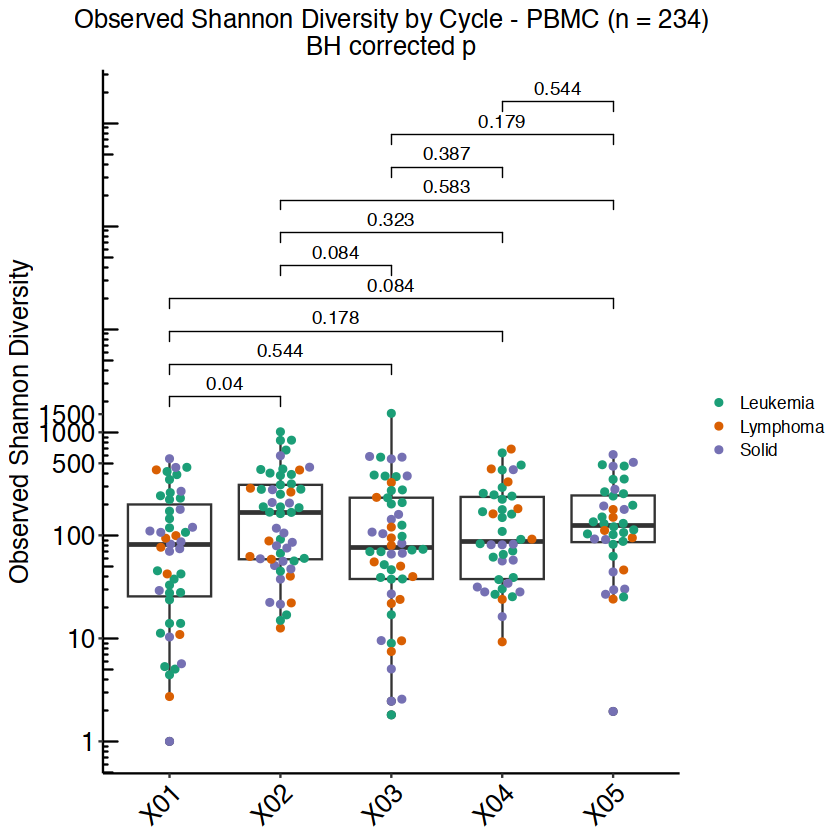

In [286]:
p_pbmc

In [415]:
summary(aov(log10shann ~ cycle, pbmc_noLFS))

             Df Sum Sq Mean Sq F value Pr(>F)  
cycle         4   4.10  1.0249   3.181 0.0144 *
Residuals   229  73.78  0.3222                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [420]:
colnames(pbmc_noLFS)

[1] "sample_id"          "Patient"            "cycle"             
 [4] "FOLD"               "ATC"                "Age"               
 [7] "Disease_type"       "TE_fold"            "Pass"              
[10] "CD3"                "EM"                 "CM"                
[13] "Naïve"              "SCM"                "TE"                
[16] "EM."                "CM."                "Naïve."            
[19] "SCM."               "TE."                "Naïve.TE"          
[22] "N.CM.SCM.TE.EM"     "PD.1"               "PDL1"              
[25] "LAG3"               "TIM3"               "CTLA4"             
[28] "PD1."               "PDL1."              "LAG3."             
[31] "TIM3."              "CTLA4."             "Any.NCR"           
[34] "PD1...LAG3...TIM3"  "cancergroup"        "TRB"               
[37] "Reads"              "CPKR"               "Average_reads"     
[40] "VMR"                "Max_reads"          "Singletons"        
[43] "Doubletons"         "qD"                 "Sample_Coverage"   
[46] "observed_Richness"  "estimated_Richness" "SE_Richeness"      
[49] "observed_Shannon"   "estimated_Shannon"  "SE_Shannon"        
[52] "observed_Simpson"   "estimated_Simpson"  "SE_Simpson"        
[55] "file"               "basename"           "Group"             
[58] "sampletype"         "log10shann"

In [419]:
myfit <- lm(log10shann ~ cycle + Disease_type + Age, pbmc_noLFS)
summary(myfit)


Call:
lm(formula = log10shann ~ cycle + Disease_type, data = pbmc_noLFS)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.66559 -0.29446  0.06539  0.35112  1.31509 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)         1.875094   0.286304   6.549 4.33e-10 ***
cycleX02            0.379076   0.112446   3.371  0.00089 ***
cycleX03            0.109340   0.113612   0.962  0.33695    
cycleX04            0.253900   0.120587   2.106  0.03643 *  
cycleX05            0.301428   0.122498   2.461  0.01467 *  
Disease_typeALL    -0.061404   0.289128  -0.212  0.83202    
Disease_typeAML     0.138965   0.299389   0.464  0.64301    
Disease_typeARMS    0.323764   0.482168   0.671  0.50265    
Disease_typeBL     -0.148576   0.329512  -0.451  0.65253    
Disease_typeBLL    -0.149342   0.393387  -0.380  0.70460    
Disease_typeCML    -0.145182   0.348155  -0.417  0.67710    
Disease_typeDLBCL  -0.337612   0.374123  -0.902  0.36787    
Disease_typeER

In [418]:
myfit <- aov(log10shann ~ cycle + Disease_type , pbmc_noLFS)

summary.lm(myfit)


Call:
aov(formula = log10shann ~ cycle + Disease_type, data = pbmc_noLFS)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.66559 -0.29446  0.06539  0.35112  1.31509 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)         1.875094   0.286304   6.549 4.33e-10 ***
cycleX02            0.379076   0.112446   3.371  0.00089 ***
cycleX03            0.109340   0.113612   0.962  0.33695    
cycleX04            0.253900   0.120587   2.106  0.03643 *  
cycleX05            0.301428   0.122498   2.461  0.01467 *  
Disease_typeALL    -0.061404   0.289128  -0.212  0.83202    
Disease_typeAML     0.138965   0.299389   0.464  0.64301    
Disease_typeARMS    0.323764   0.482168   0.671  0.50265    
Disease_typeBL     -0.148576   0.329512  -0.451  0.65253    
Disease_typeBLL    -0.149342   0.393387  -0.380  0.70460    
Disease_typeCML    -0.145182   0.348155  -0.417  0.67710    
Disease_typeDLBCL  -0.337612   0.374123  -0.902  0.36787    
Disease_typeE

In [273]:
dim(cfdna)

[1] 270  59

In [332]:
# make a box plot and beeswarm plot y = observed_Shannon, x = cancergroup
p_cfnda <- ggplot(
  cfdna,
  aes(x = cycle, y = log10shann)
) +
  geom_boxplot() + #  
  geom_beeswarm(aes(color = cancergroup), cex = 1) +
  scale_color_manual(values= group_col[c("Leukemia", "Lymphoma", "Solid")]) +
  myplot +
  myaxis +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1),
    axis.title.x = element_blank()
  ) +
  annotation_logticks(sides = "l") +
  #scale_y_continuous(breaks = log10(c(1,10,100,500,1000, 1500) ) , labels = c(1,10,100,500,1000, 1500)) +
  geom_pwc(
    mapping = aes(x = cycle, y = log10shann), data = cfdna,
    p.adjust.method = "BH", label = "{p.adj}",
    p.adjust.by = "group", method = "t_test", step.increase = 0.1
  ) + # does not allow multiple testing, shows pool.sd = F
  labs(title = "Observed Shannon Diversity by Cycle - cfDNA (n = 270)\nBH corrected p", y = "Observed Shannon Diversity")

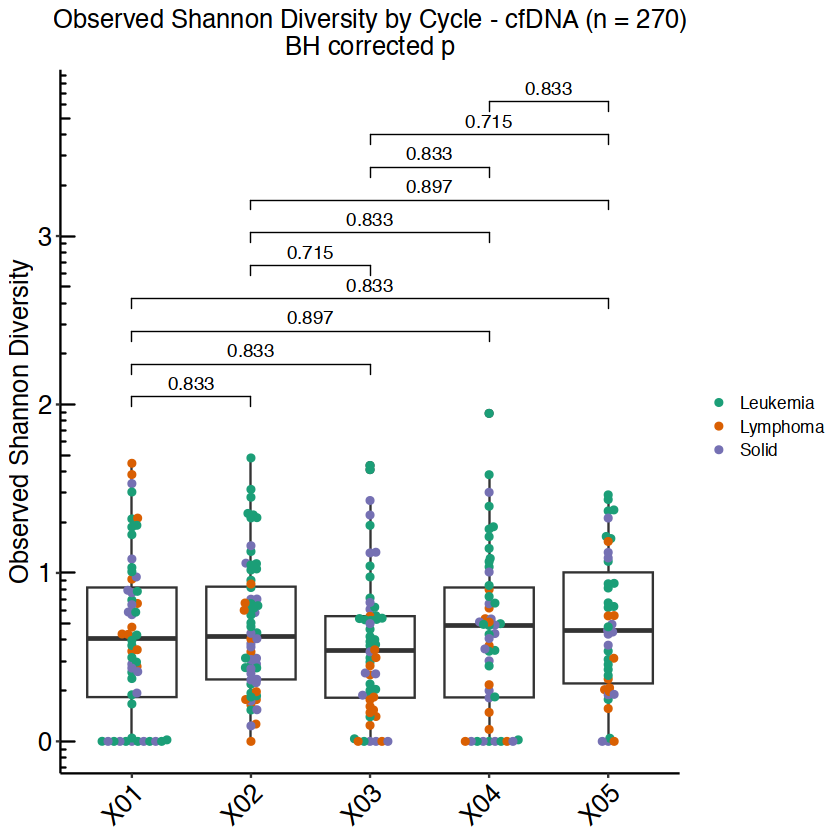

In [333]:
p_cfnda

In [402]:
mytab <- table(pbmc_noLFS$Patient, pbmc_noLFS$cycle) 

In [403]:
#select Patient with cycle 1 and 2
mytab <- mytab[mytab[,1] > 0 & mytab[,2] > 0,]

In [404]:
tmp <- pbmc_noLFS[which(pbmc_noLFS$Patient %in% rownames(mytab)),]
paired_pbmc <- tmp[ tmp$cycle %in% c("X01", "X02"),]

In [405]:
dim(paired_pbmc)

[1] 64 59

In [406]:
pairwise.t.test(paired_pbmc$log10shann, paired_pbmc$cycle, p.adjust.method = "none", pool.sd = F, paired = T)


	Pairwise comparisons using paired t tests 

data:  paired_pbmc$log10shann and paired_pbmc$cycle 

    X01  
X02 0.036

P value adjustment method: none 

In [407]:
table(paired_pbmc$Disease_type)


  ALCL    ALL    AML    BLL    CML   ERMS    EWS     HB     HD HR ALL     NB 
     2     12      6      2      4      2      6      4      4     10      2 
    OS  T-ALL 
     8      2 

In [408]:
# make a box plot and beeswarm plot y = observed_Shannon, x = cancergroup
p_pbmc_paired <- ggplot(
  paired_pbmc,
  aes(x = cycle, y = log10shann)
) +
  geom_boxplot() + #  
  geom_point(aes(color = cancergroup), cex = 2) +
  geom_line(aes(group = Patient, color = cancergroup)) + 
  scale_color_manual(values= group_col[c("Leukemia", "Lymphoma", "Solid")]) +
  myplot +
  myaxis +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1),
    axis.title.x = element_blank()
  ) +
  annotation_logticks(sides = "l") +
  scale_y_continuous(breaks = log10(c(1,10,100,500,1000, 1500) ) , labels = c(1,10,100,500,1000, 1500)) +
  geom_pwc(
    mapping = aes(x = cycle, y = log10shann), data = paired_pbmc,
    p.adjust.method = "none", label = "{p.adj}",
    p.adjust.by = "group", method = "t_test", step.increase = 0.1) + # shows pool.sd = F
  labs(title = "Observed Shannon Diversity by Cycle - PBMC (n = 234)\nBH corrected p", y = "Observed Shannon Diversity") +
  # make facet
    facet_wrap(~cancergroup, nrow = 1)

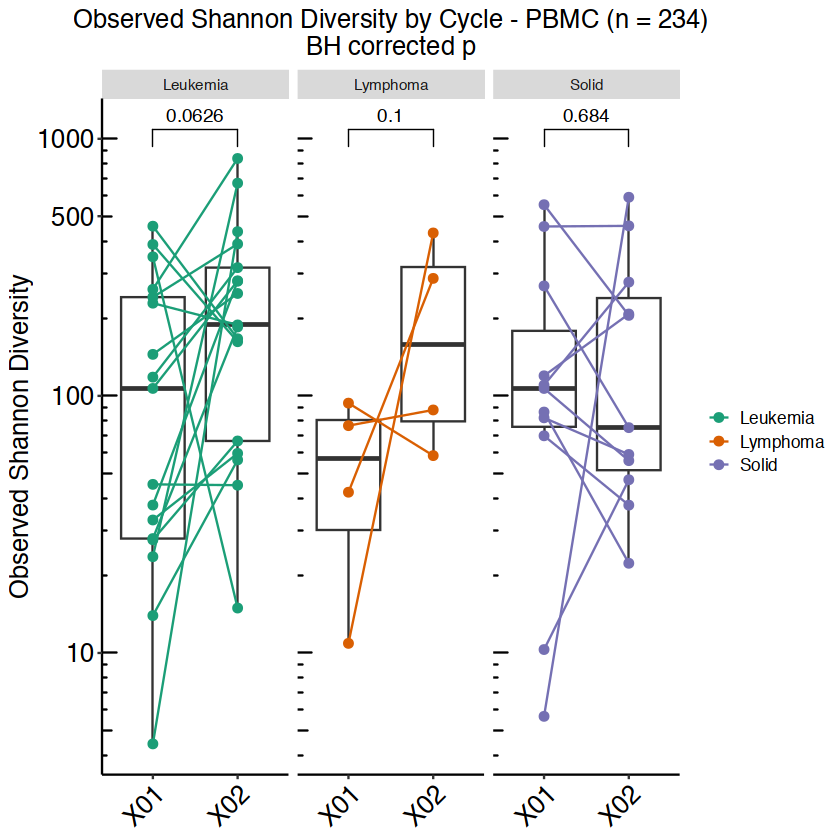

In [409]:
p_pbmc_paired